IMPORTS:

In [2]:
%run FUNCIONES_GENERALES.ipynb


In [3]:
pip install skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.5/670.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00


In [4]:
# Procesado de datos
# ==============================================================================
import os
import pandas as pd
import numpy as np
from skforecast.datasets import fetch_dataset

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Keras
# ==============================================================================
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Modelado
# ==============================================================================
import skforecast
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [5]:
columna='Valor'

RNN con LSTM:

In [7]:
#Definimos el modelo de una red neuronal recurrente con capa recurrente LSTM

def rnn (data_train,levels,steps,lags):
    model = create_and_compile_model(
        series=data_train,
        levels=levels,
        lags=lags,
        steps=steps,
        recurrent_layer="LSTM",
        recurrent_units=4,
        dense_units=16,
        optimizer=Adam(learning_rate=0.01),
        loss=MeanSquaredError()
    )
    return model

In [8]:
# Definimos el forecaster entrenado basado en el anterior modelo

def forecaster_rnn(data_train,levels,steps,lags,epochs,batch_size,data_val):
    forecaster = ForecasterRnn(
        regressor=rnn(data_train,levels,steps,lags),
        levels=levels,
        transformer_series=MinMaxScaler(),
        fit_kwargs={
            "epochs": epochs,
            "batch_size": batch_size,
            "callbacks": [
                EarlyStopping(monitor="val_loss", patience=5)
            ],
            "series_val": data_val,
        },
    )
    forecaster.fit(data_train)
    return forecaster

In [22]:
# Definimos el método para la búsqueda de los hiperparámetros
def backtesting_rnn(data,data_train,data_val,levels,steps,lags,epochs,batch_size):

    forecaster = forecaster_rnn(data_train,levels,steps,lags,epochs,batch_size,data_val)
    metrics, predictions = backtesting_forecaster_multiseries(
        forecaster=forecaster,
        steps=forecaster.max_step,
        series=data,
        levels=forecaster.levels,
        initial_train_size=len(data_train), # Datos de entrenamiento + validación
        metric='mean_squared_error',
        verbose=False,
        refit=False,
    )

    fig, ax = plt.subplots(figsize=(6, 3))
    data_val = data_val.rename(columns={data_val.columns[0]: 'test'})
    data_val.plot(ax=ax,label='Valores Reales')
    predictions = predictions.rename(columns={predictions.columns[0]: 'prediccion'})
    predictions.plot(ax=ax,label='Predicción')

    ax.set_xlabel('Tiempo')
    ax.set_ylabel(data.columns[0])

    plt.legend()
    plt.show()
    return metrics.loc[0, 'mean_squared_error']

TENDENCIA DETERMINISTA

In [23]:
# División en train y test:
df1_train = df_csv('Datos/Determinista','Lineal-det-fin-train')
df1_test = df_csv('Datos/Determinista','Lineal-det-fin-test')
df1=pd.concat([df1_train,df1_test])
df1.index.freq='ME'

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.3032 - val_loss: 0.1537
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0893 - val_loss: 0.0518
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0412 - val_loss: 0.0141
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0204 - val_loss: 0.0235
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0122 - val_loss: 0.0256
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0047 - val_loss: 0.0313
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028 - val_loss: 0.0256
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - val_loss: 0.0200
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 5.3557e-04 - val_loss: 0.0186
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9133e-04 - val_loss: 0.0187
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.4375e-05 - val_loss: 0.0185
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.1937e-05 - val_loss: 0.0180
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.8421e-05 - val_loss: 0.0184


  0%|          | 0/8 [00:00<?, ?it/s]

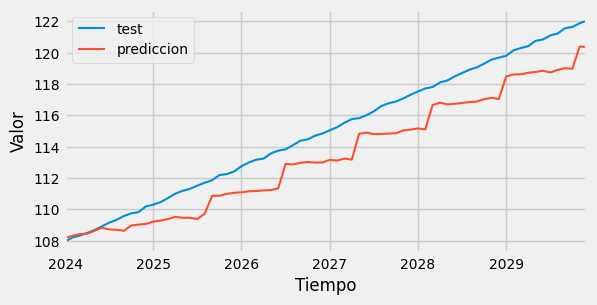

2.9638852865903904

In [24]:
backtesting_rnn(df1,df1_train,df1_test,[columna],10,20,8,30)

In [25]:
# División en train y test:
df2_train = df_csv('Datos/Determinista','Pol-det-periodos-train')
df2_test = df_csv('Datos/Determinista','Pol-det-periodos-test')
df2=pd.concat([df2_train,df2_test])
df2.index.freq='ME'

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0778 - val_loss: 0.1174
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0427 - val_loss: 0.0474
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0209 - val_loss: 0.0475
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0123 - val_loss: 0.0525
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0074 - val_loss: 0.0336
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0028 - val_loss: 0.0167
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.0403e-04 - val_loss: 0.0105
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.8785e-04 - val_loss: 0.0062
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5275e-04 - val_loss: 0.0091
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2551e-04 - val_loss: 0.0099
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0934e-04 - val_loss: 0.0088
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.7734e-05 - val_loss: 0.0080


  0%|          | 0/8 [00:00<?, ?it/s]

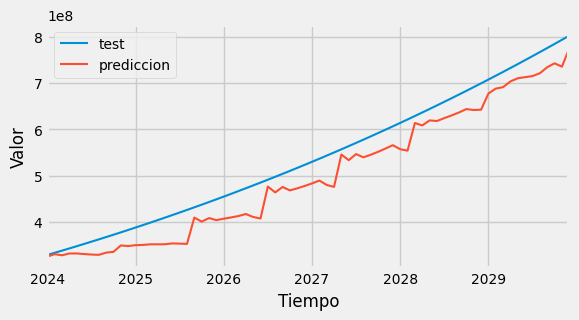

1797991193223473.0

In [27]:
backtesting_rnn(df2,df2_train,df2_test,[columna],10,20,8,30)

In [28]:
# División en train y test:
df3_train = df_csv('Datos/Determinista','Exp-det-fin-train')
df3_test = df_csv('Datos/Determinista','Exp-det-fin-test')
df3=pd.concat([df3_train,df3_test])
df3.index.freq='ME'

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 2.8659e-05 - val_loss: 1.0798e-05
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.2926e-06 - val_loss: 4.3283e-06
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.0393e-06 - val_loss: 1.9633e-06
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6679e-06 - val_loss: 9.5306e-07
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.8012e-07 - val_loss: 2.0710e-07
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8073e-07 - val_loss: 1.5353e-07
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0930e-07 - val_loss: 3.6839e-08
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2210e-07 - val_loss: 1.0794e-08
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.1101e-07 - val_loss: 1.2989e-08
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2452e-07 - val_loss: 8.3710e-09
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3309e-07 - val_loss: 1.8953e-09
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0422e-07 - val_loss: 1.3240e-08
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0823e-07 - val_loss: 4.8240e-09
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.8800e-08 - val_loss: 4.5275e-09
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2907e-07 - val_loss: 3.3474e-09
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3676e-07 - val_loss: 1.3027e-08


  0%|          | 0/8 [00:00<?, ?it/s]

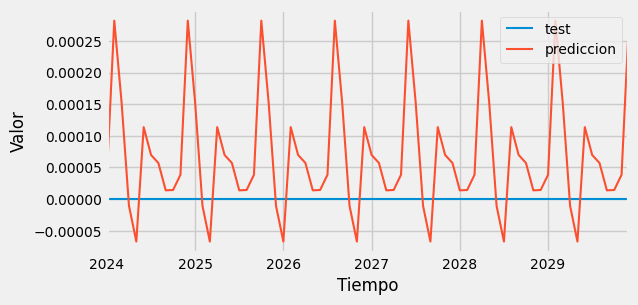

1.3791248096578993e-08

In [29]:
backtesting_rnn(df3,df3_train,df3_test,[columna],10,20,8,30)

In [30]:
# División en train y test:
df4_train = df_csv('Datos/Determinista','Log-det-periodos-train')
df4_test = df_csv('Datos/Determinista','Log-det-periodos-test')
df4=pd.concat([df4_train,df4_test])
df4.index.freq='ME'

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0206 - val_loss: 0.0300
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0064 - val_loss: 0.0233
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0037 - val_loss: 0.0302
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - val_loss: 0.0217
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5869e-04 - val_loss: 0.0089
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7185e-04 - val_loss: 0.0095
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.1945e-05 - val_loss: 0.0067
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0947e-05 - val_loss: 0.0062
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 2.6999e-05 - val_loss: 0.0060
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6337e-05 - val_loss: 0.0059
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6557e-05 - val_loss: 0.0059
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2990e-05 - val_loss: 0.0057
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1972e-05 - val_loss: 0.0056
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0830e-05 - val_loss: 0.0056
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0002e-05 - val_loss: 0.0057
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.7642e-06 - val_loss: 0.0058


  0%|          | 0/8 [00:00<?, ?it/s]

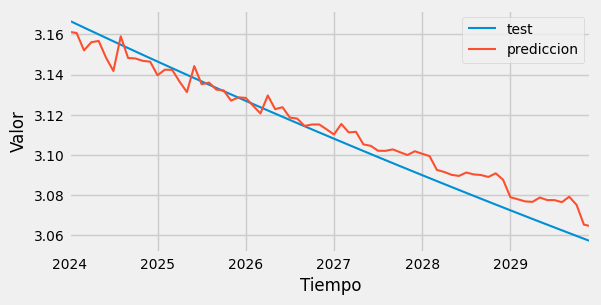

5.996101641154628e-05

In [32]:
backtesting_rnn(df4,df4_train,df4_test,[columna],10,20,8,30)

DATOS CON DISTRIBUCIONES

In [33]:
# División en train y test:
df5 = df_csv('Datos/Distribuciones','Normal-fin')
df5_train = df5[:288]
df5_test = df5[288:]
df5.index.freq='ME'

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.2464 - val_loss: 0.1385
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0867 - val_loss: 0.0768
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0489 - val_loss: 0.0639
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0375 - val_loss: 0.0652
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0381 - val_loss: 0.0619
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0362 - val_loss: 0.0620
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0366 - val_loss: 0.0614
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0359 - val_loss: 0.0614


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0355 - val_loss: 0.0617
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0354 - val_loss: 0.0614
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0353 - val_loss: 0.0615
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0361 - val_loss: 0.0614
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0360 - val_loss: 0.0614
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0357 - val_loss: 0.0613
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0362 - val_loss: 0.0615
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0354 - val_loss: 0.0614


  0%|          | 0/8 [00:00<?, ?it/s]

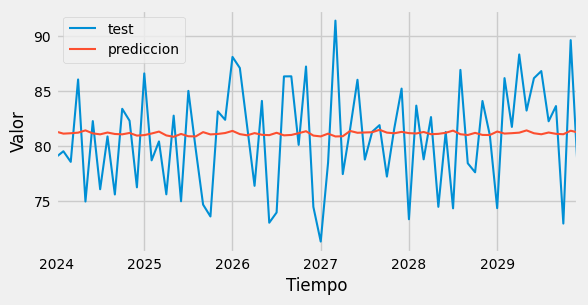

22.706089452823722

In [35]:
backtesting_rnn(df5,df5_train,df5_test,[columna],10,20,8,30)

In [36]:
# División en train y test:
df6 = df_csv('Datos/Distribuciones','Binomial-periodos')
df6_train = df6[:288]
df6_test = df6[288:]
df6.index.freq='ME'

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.2236 - val_loss: 0.0731
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0684 - val_loss: 0.0391
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0336 - val_loss: 0.0313
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0317 - val_loss: 0.0321
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0293 - val_loss: 0.0310
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0286 - val_loss: 0.0298
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0282 - val_loss: 0.0305
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0285 - val_loss: 0.0301


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0286 - val_loss: 0.0302
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0296 - val_loss: 0.0300
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0299 - val_loss: 0.0302
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0287 - val_loss: 0.0302
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0284 - val_loss: 0.0298
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0287 - val_loss: 0.0303
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0285 - val_loss: 0.0301
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0289 - val_loss: 0.0304


  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:730: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.42857143 0.57142857 0.28571429 0.42857143 0.42857143 0.42857143
 0.21428571 0.57142857 0.57142857 0.28571429 0.42857143 0.35714286
 0.21428571 0.42857143 0.42857143 0.42857143 0.57142857 0.78571429
 0.57142857 0.28571429]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:730: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.42857143 0.35714286 0.21428571 0.42857143 0.42857143 0.42857143
 0.57142857 0.78571429 0.57142857 0.28571429 0.64285714 0.57142857
 0.35714286 0.28571429 0.35714286 0.5        1.         0.35714286
 0.42857143 0.64285714]' has dtype incompatible with int64, please explic

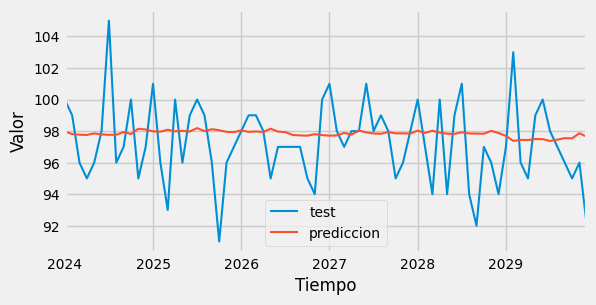

6.837732460300483

In [38]:
backtesting_rnn(df6,df6_train,df6_test,[columna],10,20,8,30)

In [39]:
# División en train y test:
df7 = df_csv('Datos/Distribuciones','Geometrica-fin')
df7_train = df7[:288]
df7_test = df7[288:]
df7.index.freq='ME'

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0456 - val_loss: 0.0296
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0299 - val_loss: 0.0273
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0296 - val_loss: 0.0268
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0283 - val_loss: 0.0270
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0278 - val_loss: 0.0270
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0283 - val_loss: 0.0269
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0282 - val_loss: 0.0268
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0280 - val_loss: 0.0269
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0284 - val_loss: 0.0270
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0278 - val_loss: 0.0269
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0294 - val_loss: 0.0269
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0277 - val_loss: 0.0269
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0292 - val_loss: 0.0270


  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:730: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21428571 0.07142857 0.42857143 0.         0.42857143 0.14285714
 0.28571429 0.         0.14285714 0.14285714 0.14285714 0.
 0.         0.         0.         0.5        0.         0.78571429
 0.14285714 0.07142857]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:730: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.14285714 0.         0.         0.         0.         0.5
 0.         0.78571429 0.14285714 0.07142857 0.14285714 0.
 0.         0.64285714 0.07142857 0.07142857 0.07142857 0.07142857
 0.         0.21428571]' has dtype incompatible with int64, please explicitly cast to a compatib

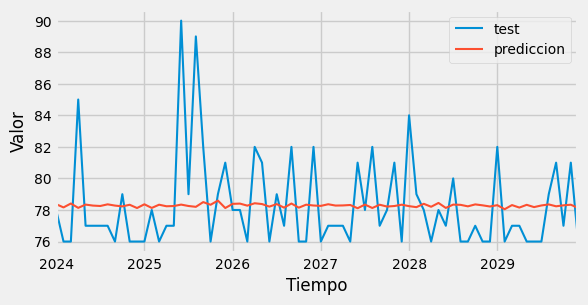

8.602269735408804

In [40]:
backtesting_rnn(df7,df7_train,df7_test,[columna],10,20,8,30)

In [41]:
# División en train y test:
dfg = df_csv('Datos/Distribuciones','Poisson-periodos')
dfg_train = dfg[:288]
dfg_test = dfg[288:]
dfg.index.freq='ME'

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1626 - val_loss: 0.1097
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0600 - val_loss: 0.0555
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0345 - val_loss: 0.0543
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0338 - val_loss: 0.0522
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0318 - val_loss: 0.0520
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0305 - val_loss: 0.0517
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0298 - val_loss: 0.0518
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0307 - val_loss: 0.0515
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0302 - val_loss: 0.0521
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0300 - val_loss: 0.0512
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0312 - val_loss: 0.0521
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0305 - val_loss: 0.0512
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0300 - val_loss: 0.0520
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0323 - val_loss: 0.0515
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0318 - val_loss: 0.0518


  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:730: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.45454545 0.36363636 0.36363636 0.18181818 0.63636364 0.27272727
 0.36363636 0.54545455 0.18181818 0.54545455 0.72727273 0.09090909
 0.36363636 0.45454545 0.54545455 0.72727273 0.27272727 0.27272727
 0.27272727 0.72727273]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:730: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.72727273 0.09090909 0.36363636 0.45454545 0.54545455 0.72727273
 0.27272727 0.27272727 0.27272727 0.72727273 0.54545455 0.45454545
 0.54545455 0.36363636 0.81818182 0.27272727 0.18181818 0.09090909
 0.18181818 0.27272727]' has dtype incompatible with int64, please explic

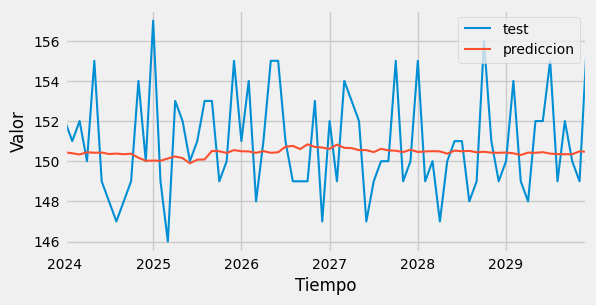

6.878749042118822

In [42]:
backtesting_rnn(dfg,dfg_train,dfg_test,[columna],10,20,8,30)

In [43]:
# Dividimos en train y test
df8 = df_csv('Datos/Distribuciones','Hipergeometrica-fin')
df8_train = df8[:288]
df8_test = df8[288:]
df8.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.2624 - val_loss: 0.1522
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1167 - val_loss: 0.0843
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0495 - val_loss: 0.0621
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0405 - val_loss: 0.0632
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0407 - val_loss: 0.0617
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0382 - val_loss: 0.0613
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0382 - val_loss: 0.0613
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0380 - val_loss: 0.0608


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0392 - val_loss: 0.0612
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0397 - val_loss: 0.0610
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0379 - val_loss: 0.0609
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0375 - val_loss: 0.0613
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0395 - val_loss: 0.0610


  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:730: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.125 0.5   0.5   0.5   0.25  0.625 0.875 0.375 0.875 0.25  0.    0.375
 0.5   0.5   0.625 0.375 0.625 0.25  0.625 0.5  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:730: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.    0.375 0.5   0.5   0.625 0.375 0.625 0.25  0.625 0.5   0.125 0.375
 0.25  0.375 0.5   0.25  0.625 0.5   0.625 0.625]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:730: FutureWarning:

Setting an item of incompatible dtype is deprecated and will 

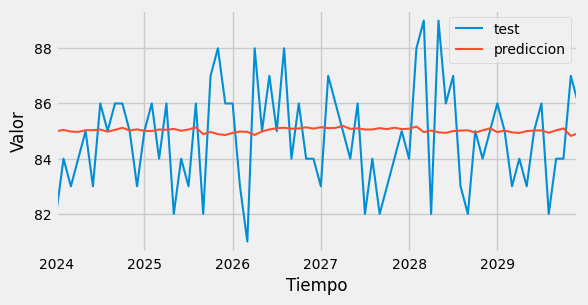

3.4680374791059876

In [44]:
backtesting_rnn(df8,df8_train,df8_test,[columna],10,20,8,30)

In [45]:
df9 = df_csv('Datos/Distribuciones','Uniforme-periodos')
df9_train = df9[:288]
df9_test = df9[288:]
df9.index.freq='ME'

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.3368 - val_loss: 0.2501
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2539 - val_loss: 0.1861
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1961 - val_loss: 0.1399
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1498 - val_loss: 0.1095
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1199 - val_loss: 0.0915
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0992 - val_loss: 0.0823
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0900 - val_loss: 0.0784
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0862 - val_loss: 0.0773
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0840 - val_loss: 0.0773
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0822 - val_loss: 0.0775
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0822 - val_loss: 0.0777
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0838 - val_loss: 0.0778
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0842 - val_loss: 0.0778
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0825 - val_loss: 0.0778


  0%|          | 0/8 [00:00<?, ?it/s]

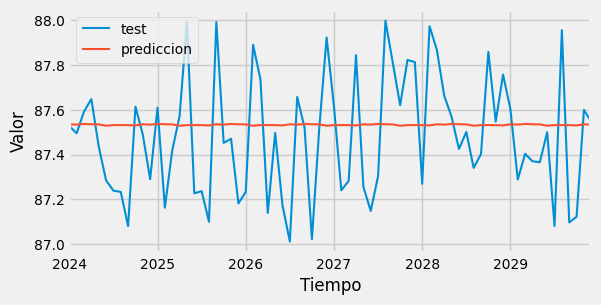

0.07470141496280112

In [46]:
backtesting_rnn(df9,df9_train,df9_test,[columna],10,20,8,30)

In [47]:
# División en train y test:
df10 = df_csv('Datos/Distribuciones','Constante-fin')
df10_train = df10[:288]
df10_test = df10[288:]
df10.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00


  0%|          | 0/8 [00:00<?, ?it/s]

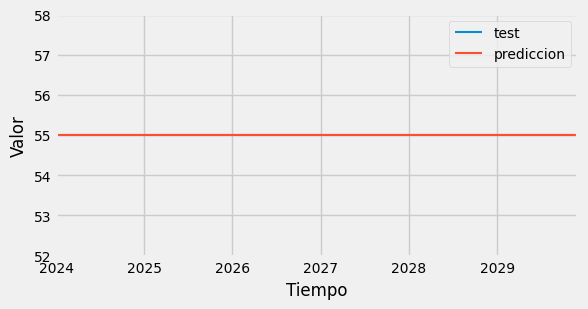

0.0

In [48]:
backtesting_rnn(df10,df10_train,df10_test,[columna],10,20,8,30)

In [49]:
# División en train y test:
df11 = df_csv('Datos/Distribuciones','Gamma-periodos')
df11_train = df11[:288]
df11_test = df11[288:]
df11.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.1545 - val_loss: 0.0811
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0833 - val_loss: 0.0575
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0546 - val_loss: 0.0494
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0465 - val_loss: 0.0517
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0467 - val_loss: 0.0507
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0465 - val_loss: 0.0503
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0444 - val_loss: 0.0498
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0462 - val_loss: 0.0497
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0448 - val_loss: 0.0496
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0460 - val_loss: 0.0501
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0467 - val_loss: 0.0493
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0477 - val_loss: 0.0499
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0444 - val_loss: 0.0500
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0452 - val_loss: 0.0496
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0445 - val_loss: 0.0499
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0459 - val_loss: 0.0499


  0%|          | 0/8 [00:00<?, ?it/s]

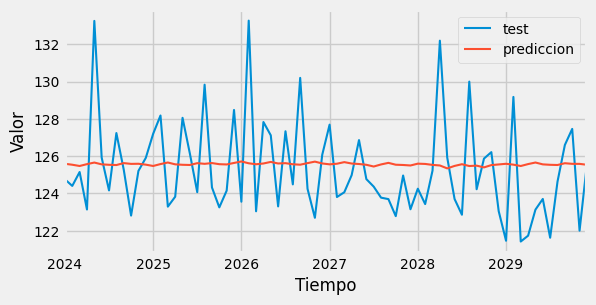

6.823485986532298

In [50]:
backtesting_rnn(df11,df11_train,df11_test,[columna],10,20,8,30)

In [51]:
# División en train y test:
df12 = df_csv('Datos/Distribuciones','Beta-fin')
df12_train = df12[:288]
df12_test = df12[288:]
df12.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.2263 - val_loss: 0.1322
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0957 - val_loss: 0.0728
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0487 - val_loss: 0.0651
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0478 - val_loss: 0.0647
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0467 - val_loss: 0.0650
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0439 - val_loss: 0.0645
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0453 - val_loss: 0.0644
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0442 - val_loss: 0.0647
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0452 - val_loss: 0.0645
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0447 - val_loss: 0.0646
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0443 - val_loss: 0.0646
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0458 - val_loss: 0.0643
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0433 - val_loss: 0.0648
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0464 - val_loss: 0.0646
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0442 - val_loss: 0.0645
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0453 - val_loss: 0.0646


  0%|          | 0/8 [00:00<?, ?it/s]

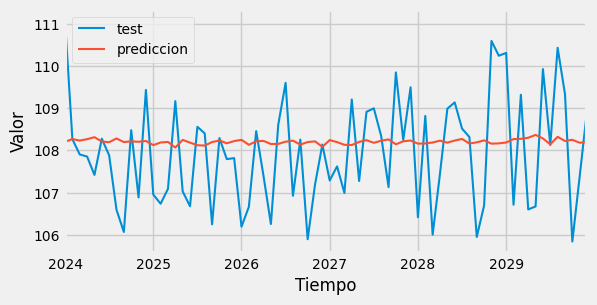

1.718402750127507

In [52]:
backtesting_rnn(df12,df12_train,df12_test,[columna],10,20,8,30)

In [53]:
# División en train y test:
df13 = df_csv('Datos/Distribuciones','Exponencial-periodos')
df13_train = df13[:288]
df13_test = df13[288:]
df13.index.freq='ME'


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0518 - val_loss: 0.0623
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0363 - val_loss: 0.0608
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0365 - val_loss: 0.0612
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0363 - val_loss: 0.0602
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0357 - val_loss: 0.0606
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0364 - val_loss: 0.0603
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0355 - val_loss: 0.0603
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0350 - val_loss: 0.0602


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0348 - val_loss: 0.0604
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0350 - val_loss: 0.0600
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0348 - val_loss: 0.0603
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0331 - val_loss: 0.0602
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0362 - val_loss: 0.0603
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0374 - val_loss: 0.0603
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0353 - val_loss: 0.0602


  0%|          | 0/8 [00:00<?, ?it/s]

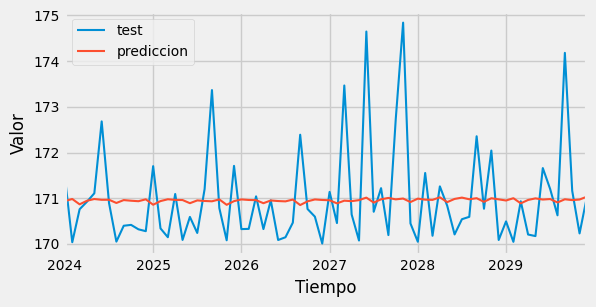

1.1517942511413268

In [54]:
backtesting_rnn(df13,df13_train,df13_test,[columna],10,20,8,30)

In [55]:
# División en train y test:
df14 = df_csv('Datos/Distribuciones','Chi_cuadrado-fin')
df14_train = df14[:288]
df14_test = df14[288:]
df14.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.0380 - val_loss: 0.0715
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0227 - val_loss: 0.0648
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0216 - val_loss: 0.0701
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0225 - val_loss: 0.0692
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0226 - val_loss: 0.0696
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0230 - val_loss: 0.0690
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0214 - val_loss: 0.0692
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0214 - val_loss: 0.0686
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0217 - val_loss: 0.0695
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0225 - val_loss: 0.0689
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0233 - val_loss: 0.0691
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0220 - val_loss: 0.0692


  0%|          | 0/8 [00:00<?, ?it/s]

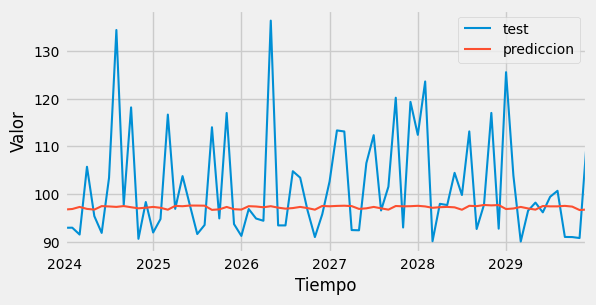

137.30066392737777

In [56]:
backtesting_rnn(df14,df14_train,df14_test,[columna],10,20,8,30)

In [57]:
# División en train y test:
df15 = df_csv('Datos/Distribuciones','T_Student-periodos')
df15_train = df15[:288]
df15_test = df15[288:]
df15.index.freq='ME'

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.2673 - val_loss: 0.1030
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1051 - val_loss: 0.0475
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0322 - val_loss: 0.0354
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0207 - val_loss: 0.0386
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0210 - val_loss: 0.0365
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0202 - val_loss: 0.0378
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0183 - val_loss: 0.0432
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0175 - val_loss: 0.0421


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0174 - val_loss: 0.0388
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0178 - val_loss: 0.0449
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0180 - val_loss: 0.0436
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0188 - val_loss: 0.0401
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0181 - val_loss: 0.0387


  0%|          | 0/8 [00:00<?, ?it/s]

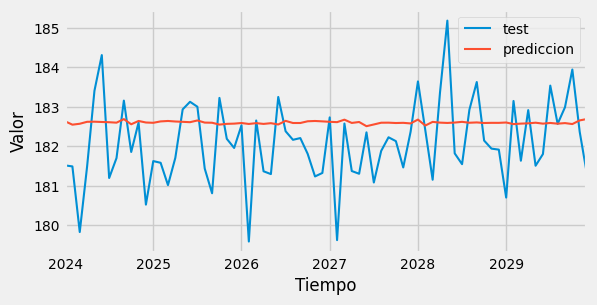

1.3039483464543868

In [58]:
backtesting_rnn(df15,df15_train,df15_test,[columna],10,20,8,30)

In [59]:
# División en train y test:
df16 = df_csv('Datos/Distribuciones','Lognormal-fin')
df16_train = df16[:288]
df16_test = df16[288:]
df16.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0099 - val_loss: 0.0359
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0087 - val_loss: 0.0367
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0109 - val_loss: 0.0359
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0112 - val_loss: 0.0363
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0100 - val_loss: 0.0364
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0109 - val_loss: 0.0362
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0070 - val_loss: 0.0364
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0114 - val_loss: 0.0359


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0103 - val_loss: 0.0364
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0099 - val_loss: 0.0363
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0097 - val_loss: 0.0361
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0102 - val_loss: 0.0361
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0115 - val_loss: 0.0364


  0%|          | 0/8 [00:00<?, ?it/s]

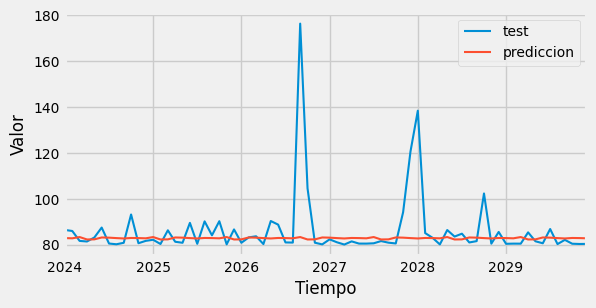

206.30088972822026

In [60]:
backtesting_rnn(df16,df16_train,df16_test,[columna],10,20,8,30)

In [61]:
# División en train y test:
df17 = df_csv('Datos/Distribuciones','Pareto-periodos')
df17_train = df17[:288]
df17_test = df17[288:]
df17.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0390 - val_loss: 0.0118
Epoch 2/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0293 - val_loss: 0.0127
Epoch 3/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0224 - val_loss: 0.0157
Epoch 4/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0222 - val_loss: 0.0173
Epoch 5/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0239 - val_loss: 0.0169
Epoch 6/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0240 - val_loss: 0.0156
Epoch 1/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0218 - val_loss: 0.0145
Epoch 2/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0216 - val_loss: 0.0138
Epoch 3/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0212 - val_loss: 0.0137
Epoch 4/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0224 - val_loss: 0.0139
Epoch 5/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0200 - val_loss: 0.0141


  0%|          | 0/22 [00:00<?, ?it/s]

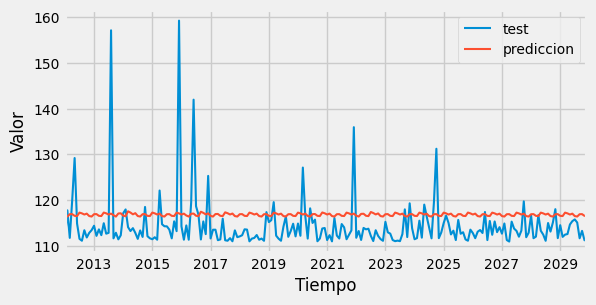

38.3761734491293

In [62]:
backtesting_rnn(df17,df17,df17,[columna],10,20,8,30)

In [64]:
# División en train y test:
df18 = df_csv('Datos/Distribuciones','Lineal-asc-fin')
df18_train = df18[:288]
df18_test = df18[288:]
df18.index.freq='ME'


keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.2880 - val_loss: 0.1615
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0973 - val_loss: 0.0296
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0204 - val_loss: 0.0135
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0091 - val_loss: 0.0198
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0051 - val_loss: 0.0171
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025 - val_loss: 0.0157
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 0.0129
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.0233e-04 - val_loss: 0.0123
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 5.1947e-04 - val_loss: 0.0121
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.8170e-04 - val_loss: 0.0113
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5036e-04 - val_loss: 0.0114
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0747e-04 - val_loss: 0.0110
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.3403e-05 - val_loss: 0.0115
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.8601e-05 - val_loss: 0.0107
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8024e-05 - val_loss: 0.0109
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.6670e-05 - val_loss: 0.0109


  0%|          | 0/8 [00:00<?, ?it/s]

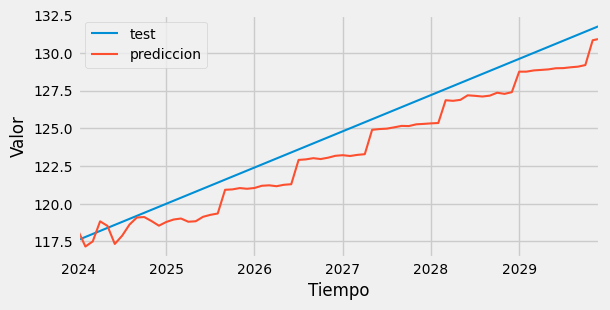

1.965314044213679

In [67]:
backtesting_rnn(df18,df18_train,df18_test,[columna],10,20,8,30)

In [66]:
# División en train y test:
df19 = df_csv('Datos/Distribuciones','Lineal-desc-periodos')
df19_train = df19[:288]
df19_test = df19[288:]
df19.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.2026 - val_loss: 0.0640
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0452 - val_loss: 0.0534
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0138 - val_loss: 0.0419
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0093 - val_loss: 0.0262
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0044 - val_loss: 0.0198
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - val_loss: 0.0236
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.4431e-04 - val_loss: 0.0214
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1334e-04 - val_loss: 0.0217
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 9.9108e-05 - val_loss: 0.0216
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.0335e-05 - val_loss: 0.0219
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.2138e-05 - val_loss: 0.0218
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.9497e-05 - val_loss: 0.0216
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.0498e-05 - val_loss: 0.0208


  0%|          | 0/8 [00:00<?, ?it/s]

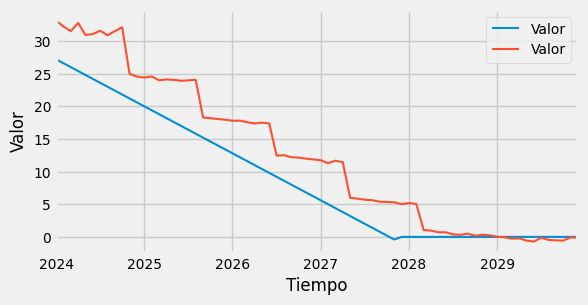

24.010556560635035

In [ ]:
backtesting_rnn(df19,df19_train,df19_test,[columna],10,20,8,30,144)

In [69]:
## División en train y test:
df20 = df_csv('Datos/Distribuciones','Aleatorio-fin')
df20_train = df20[:288]
df20_test = df20[288:]
df20.index.freq='ME'

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.2547 - val_loss: 0.1582
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1138 - val_loss: 0.1089
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0855 - val_loss: 0.1123
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0850 - val_loss: 0.1053
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0843 - val_loss: 0.1060
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0825 - val_loss: 0.1065
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0835 - val_loss: 0.1065
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0802 - val_loss: 0.1059
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0841 - val_loss: 0.1064
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0828 - val_loss: 0.1057
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0815 - val_loss: 0.1066
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0835 - val_loss: 0.1060
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0819 - val_loss: 0.1061


  0%|          | 0/8 [00:00<?, ?it/s]

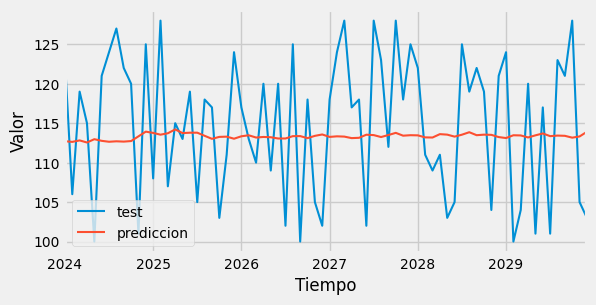

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()



81.00483678766129

In [70]:
backtesting_rnn(df20,df20_train,df20_test,[columna],10,20,8,30)

MODELOS PERIÓDICOS

In [71]:
# División en train y test:
df21 = df_csv('Datos/Periodicas','Amplitud-fin')
df21_train = df21[:288]
df21_test = df21[288:]
df21.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.2939 - val_loss: 0.1771
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1461 - val_loss: 0.0977
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0962 - val_loss: 0.0933
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0912 - val_loss: 0.0899
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0894 - val_loss: 0.0872
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0864 - val_loss: 0.0849
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0837 - val_loss: 0.0823
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0814 - val_loss: 0.0788
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0781 - val_loss: 0.0739
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0713 - val_loss: 0.0645
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0619 - val_loss: 0.0560
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0558 - val_loss: 0.0537
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0529 - val_loss: 0.0509
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0495 - val_loss: 0.0474
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0467 - val_loss: 0.0443
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0430 - val_loss: 0.0387


  0%|          | 0/8 [00:00<?, ?it/s]

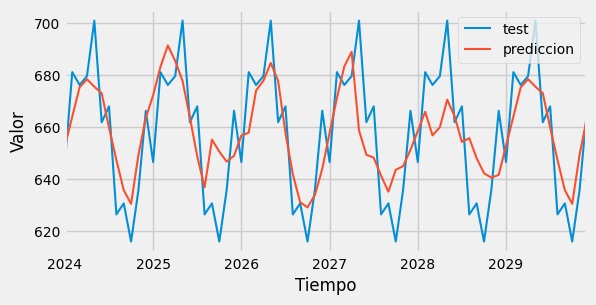

266.798488945866

In [72]:
backtesting_rnn(df21,df21_train,df21_test,[columna],10,20,8,30)

In [73]:
# División en train y test:
df22 = df_csv('Datos/Periodicas','Amplitud-periodos')
df22_train = df22[:288]
df22_test = df22[288:]
df22.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.3191 - val_loss: 0.2279
Epoch 2/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2046 - val_loss: 0.1524
Epoch 3/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1490 - val_loss: 0.1443
Epoch 4/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1382 - val_loss: 0.1262
Epoch 5/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1273 - val_loss: 0.1286
Epoch 6/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1299 - val_loss: 0.1307
Epoch 7/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1302 - val_loss: 0.1275
Epoch 8/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1270 - val_loss: 0.1242
Epoch 1/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - loss: 0.1245 - val_loss: 0.1232
Epoch 2/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1223 - val_loss: 0.1225
Epoch 3/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1228 - val_loss: 0.1222
Epoch 4/8
4/4 ━━━━━━━━

  0%|          | 0/22 [00:00<?, ?it/s]

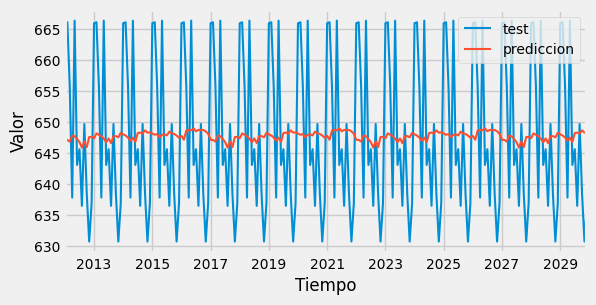

152.2088716062263

In [74]:
backtesting_rnn(df22,df22[:144],df22[144:],[columna],10,20,8,30)

In [75]:
# División en train y test:
df23 = df_csv('Datos/Periodicas','Cantidad-fin')
df23_train = df23[:288]
df23_test = df23[288:]
df23.index.freq='ME'

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.2695 - val_loss: 0.1658
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1591 - val_loss: 0.0822
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0777 - val_loss: 0.0496
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0530 - val_loss: 0.0461
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0444 - val_loss: 0.0415
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0438 - val_loss: 0.0417
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0441 - val_loss: 0.0416
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0431 - val_loss: 0.0418
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0416 - val_loss: 0.0414
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0427 - val_loss: 0.0413
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0426 - val_loss: 0.0413
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0436 - val_loss: 0.0413
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0434 - val_loss: 0.0414
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0428 - val_loss: 0.0414
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0432 - val_loss: 0.0413


  0%|          | 0/8 [00:00<?, ?it/s]

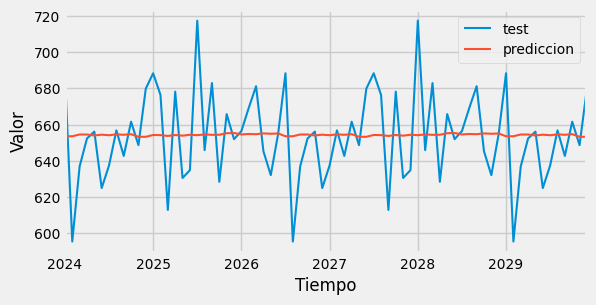

625.6827497260786

In [76]:
backtesting_rnn(df23,df23_train,df23_test,[columna],10,20,8,30)

In [77]:
# División en train y test:
df24 = df_csv('Datos/Periodicas','Cantidad-periodos')
df24_train = df24[:288]
df24_test = df24[288:]
df24.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.2867 - val_loss: 0.1462
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1202 - val_loss: 0.0871
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0775 - val_loss: 0.0778
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0723 - val_loss: 0.0766
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0708 - val_loss: 0.0759
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0718 - val_loss: 0.0751
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0705 - val_loss: 0.0751
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0698 - val_loss: 0.0751
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.



9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0695 - val_loss: 0.0749
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0702 - val_loss: 0.0749
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0677 - val_loss: 0.0748
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0693 - val_loss: 0.0749
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0696 - val_loss: 0.0748
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0707 - val_loss: 0.0748
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0698 - val_loss: 0.0748
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0677 - val_loss: 0.0748


  0%|          | 0/8 [00:00<?, ?it/s]

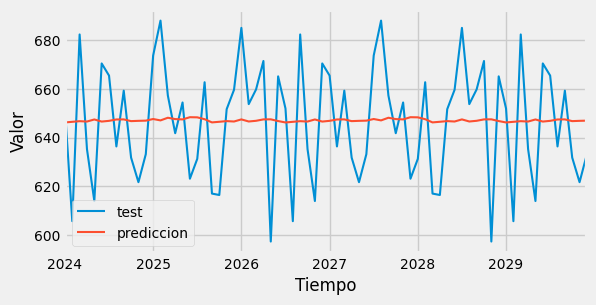

566.2882437797842

In [79]:
backtesting_rnn(df24,df24_train,df24_test,[columna],10,20,8,30)

MODELOS ARMA

In [80]:
df25 = df_csv('Datos/ARMA','AR-fin')
df25_train = df25[:288]
df25_test = df25[288:]
df25.index.freq='ME'
df25_train.index.freq='ME'
df25_test.index.freq='ME'

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.8926 - val_loss: 0.1621
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4570 - val_loss: 0.0896
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1220 - val_loss: 0.0724
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0179 - val_loss: 0.0815
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0062 - val_loss: 0.0935
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0053 - val_loss: 0.0877
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - val_loss: 0.0924
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9196e-04 - val_loss: 0.0889
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 2.7272e-04 - val_loss: 0.0922
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6104e-04 - val_loss: 0.0915
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.8515e-05 - val_loss: 0.0921
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.5333e-05 - val_loss: 0.0924
Epoch 

  0%|          | 0/8 [00:00<?, ?it/s]

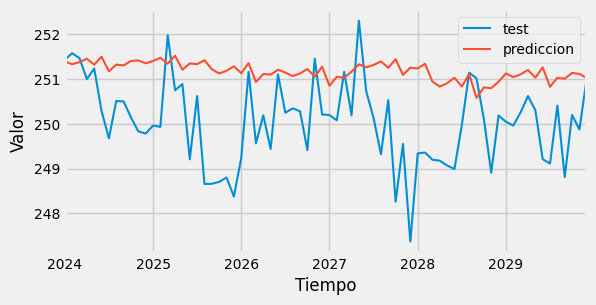

2.154144535422355

In [81]:
backtesting_rnn(df25,df25_train,df25_test,[columna],10,20,8,30)

In [82]:
df26 = df_csv('Datos/ARMA','MA-periodos')
df26_train = df26[:288]
df26_test = df26[288:]
df26.index.freq='ME'
df26_train.index.freq='ME'
df26_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.1397 - val_loss: 0.0583
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0423 - val_loss: 0.0433
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0373 - val_loss: 0.0404
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0325 - val_loss: 0.0398
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0325 - val_loss: 0.0396
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0321 - val_loss: 0.0395
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0325 - val_loss: 0.0393
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0321 - val_loss: 0.0395
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 0.0338 - val_loss: 0.0394
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0304 - val_loss: 0.0395
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0324 - val_loss: 0.0393
Epoch 4/8
9/9 ━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

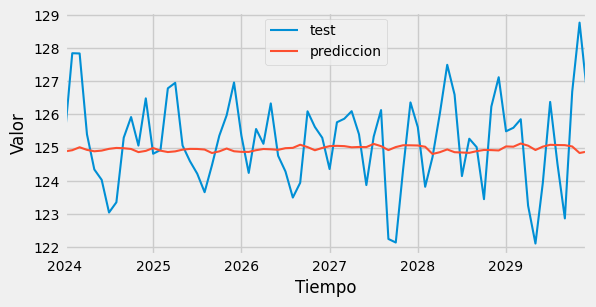

1.9527659811634832

In [83]:
backtesting_rnn(df26,df26_train,df26_test,[columna],10,20,8,30)

In [84]:
df27 = df_csv('Datos/ARMA','ARMA-fin')
df27_train = df27[:288]
df27_test = df27[288:]
df27.index.freq='ME'
df27_train.index.freq='ME'
df27_test.index.freq='ME'

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 1.1468 - val_loss: 0.1111
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4507 - val_loss: 0.0722
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0742 - val_loss: 0.0943
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0052 - val_loss: 0.1135
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0055 - val_loss: 0.1175
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0024 - val_loss: 0.1282
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.2711e-04 - val_loss: 0.1221
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 5.2277e-04 - val_loss: 0.1276
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8584e-04 - val_loss: 0.1248
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.1243e-04 - val_loss: 0.1272
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9372e-04 - val_loss: 0.1260
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7253e-04 - val_loss: 0.1269


  0%|          | 0/8 [00:00<?, ?it/s]

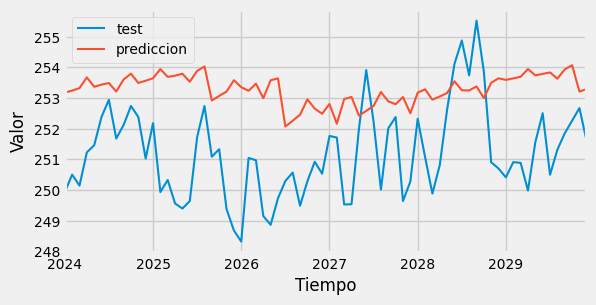

6.6129142004445685

In [85]:
backtesting_rnn(df27,df27_train,df27_test,[columna],10,20,8,30)

In [86]:
df28 = df_csv('Datos/ARMA','AR-estacional-periodos')
df28_train = df28[:288]
df28_test = df28[288:]
df28.index.freq='ME'
df28_train.index.freq='ME'
df28_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.7934 - val_loss: 0.1452
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3293 - val_loss: 0.0932
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0618 - val_loss: 0.1085
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0095 - val_loss: 0.0692
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0126 - val_loss: 0.1023
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0064 - val_loss: 0.1018
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0049 - val_loss: 0.0876
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0032 - val_loss: 0.0961
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0030 - val_loss: 0.0912
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0026 - val_loss: 0.0886
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0022 - val_loss: 0.0884
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025 - val_loss: 0.0847
Epoch 5/8
9/9 ━━━━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

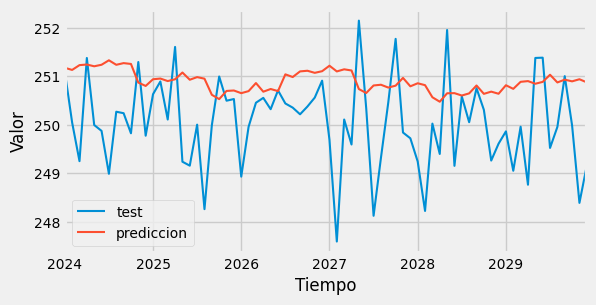

1.6228834790559776

In [87]:
backtesting_rnn(df28,df28_train,df28_test,[columna],10,20,8,30)

In [88]:
df29 = df_csv('Datos/ARMA','MA-estacional-fin')
df29_train = df29[:288]
df29_test = df29[288:]
df29.index.freq='ME'
df29_train.index.freq='ME'
df29_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2874 - val_loss: 0.1409
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1280 - val_loss: 0.0602
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0592 - val_loss: 0.0347
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0387 - val_loss: 0.0335
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0377 - val_loss: 0.0333
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0371 - val_loss: 0.0325
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0364 - val_loss: 0.0320
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0371 - val_loss: 0.0322
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0370 - val_loss: 0.0319
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0371 - val_loss: 0.0322
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0367 - val_loss: 0.0320
Epoch 4/8
9/9 ━━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

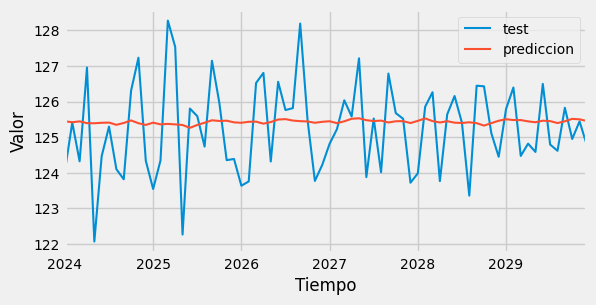

1.6155379973337698

In [89]:
backtesting_rnn(df29,df29_train,df29_test,[columna],10,20,8,30)

In [90]:
df30 = df_csv('Datos/ARMA','ARMA-estacional-periodos')
df30_train = df30[:288]
df30_test = df30[288:]
df30.index.freq='ME'
df30_train.index.freq='ME'
df30_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.8014 - val_loss: 0.2838
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4786 - val_loss: 0.1072
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1036 - val_loss: 0.0655
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0141 - val_loss: 0.0684
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0095 - val_loss: 0.0752
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0053 - val_loss: 0.0757
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0029 - val_loss: 0.0735
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - val_loss: 0.0742
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0027 - val_loss: 0.0712
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019 - val_loss: 0.0705
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - val_loss: 0.0690
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018 - val_loss: 0.0678
Epoch 5/8
9/9 ━━━━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

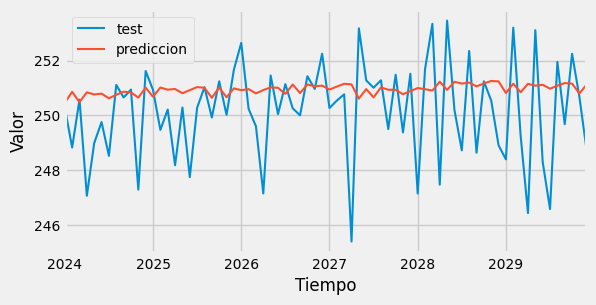

3.731904458113511

In [91]:
backtesting_rnn(df30,df30_train,df30_test,[columna],10,20,8,30)

FORECASTER AUTOREGRESIVO RANDOM FOREST


In [98]:
# Entrenamiento de modelo con regressor Random Forest y optimización hiperparámetros

def backtesting_forecasterAutoreg(datos_train,datos_test,lags,steps):

    forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = lags
                )
    # Valores candidatos de lags
    lags_grid = [10, 20]

    # Valores candidatos de hiperparámetros del regresor
    param_grid = {
         'n_estimators': [100, 175,250,450],
         'max_depth': [3, 5, 10,15,20]
    }

    resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train[datos_train.columns[0]],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.8),
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False
                    )

    # Predicciones
    # ==============================================================================
    predicciones = forecaster.predict(steps=len(datos_test))

    # Error de test
    # ==============================================================================
    error_mse = mean_squared_error(
                    y_true = datos_test,
                    y_pred = predicciones
                )

    fig, ax = plt.subplots(figsize=(6, 3))

    pred = predicciones.to_frame()
    datos_test = datos_test.rename(columns={datos_test.columns[0]: 'Test'})
    datos_test.plot(ax=ax,label='Valores Reales')

    pred = pred.rename(columns={pred.columns[0]: 'Predicción'})
    pred.plot(ax=ax,label='Predicción')

    ax.set_xlabel('Tiempo')
    ax.set_ylabel(datos_train.columns[0])

    return error_mse

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [99]:
df1_train.index.freq='ME'
df1_test.index.freq='ME'

Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 20, 'n_estimators': 100}
  Backtesting metric: 46.729936574517



72.18988675035342

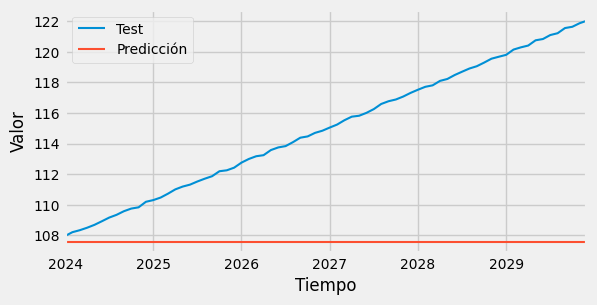

In [100]:
backtesting_forecasterAutoreg(df1_train,df1_test,32,36)

In [101]:
df2_train.index.freq='ME'
df2_test.index.freq='ME'

Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 20, 'n_estimators': 100}
  Backtesting metric: 1.1144550965404372e+16



6.6498324691737544e+16

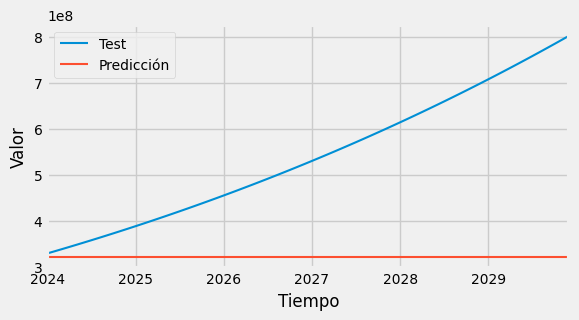

In [102]:
backtesting_forecasterAutoreg(df2_train,df2_test,32,36)

In [103]:
df3_train.index.freq='ME'
df3_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:307: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.



`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 20, 'n_estimators': 100}
  Backtesting metric: 3.2630160539623097e-18



2.9591016746259624e-18

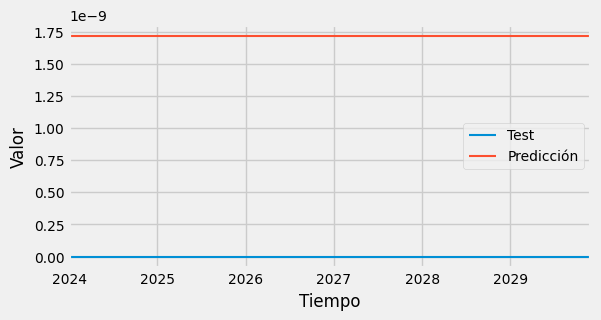

In [104]:
backtesting_forecasterAutoreg(df3_train,df3_test,32,36)

In [105]:
df4_train.index.freq='ME'
df4_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 20, 'n_estimators': 100}
  Backtesting metric: 0.004698166980159835



0.004567980532230777

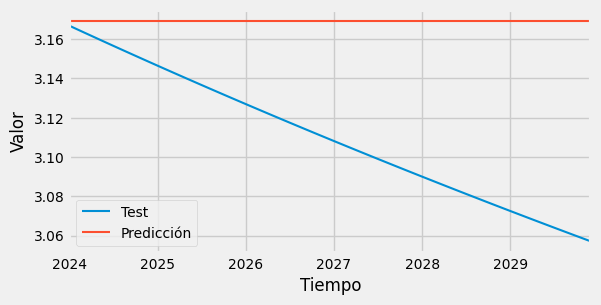

In [106]:
backtesting_forecasterAutoreg(df4_train,df4_test,32,36)

MODELOS CON DISTRIBUCIONES

In [107]:
df5_train.index.freq='ME'
df5_test.index.freq='ME'

Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 15.896329567142407



24.310833157471336

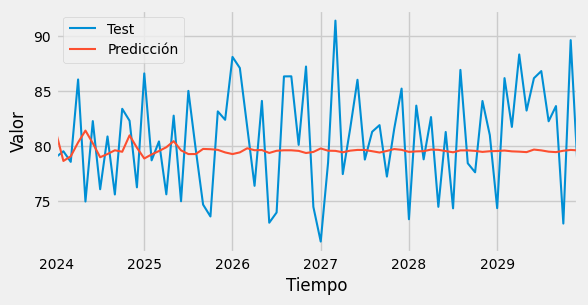

In [108]:
backtesting_forecasterAutoreg(df5_train,df5_test,32,36)

In [109]:
df6_train.index.freq='ME'
df6_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 6.256705634910523



6.438927796734835

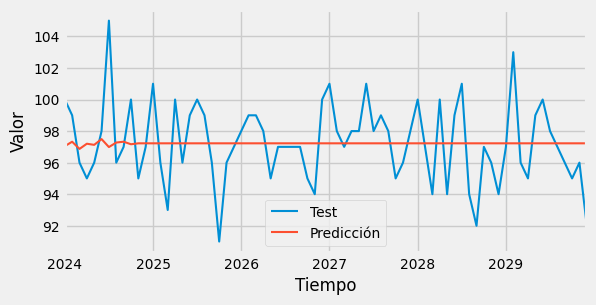

In [110]:
backtesting_forecasterAutoreg(df6_train,df6_test,32,36)

In [111]:
df7_train.index.freq='ME'
df7_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 6.261330909678777



8.59279307435404

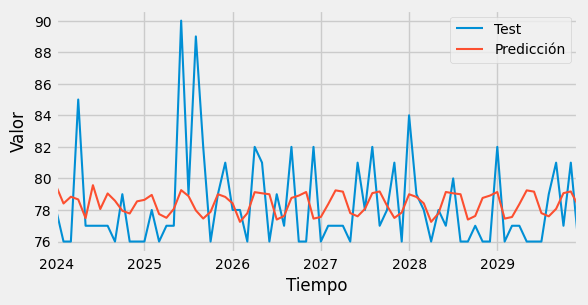

In [112]:
backtesting_forecasterAutoreg(df7_train,df7_test,32,36)

In [113]:
dfg_train.index.freq='ME'
dfg_test.index.freq='ME'

Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 250}
  Backtesting metric: 5.889096317991885



6.964972776802231

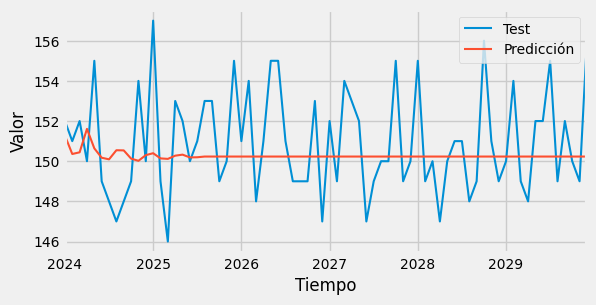

In [114]:
backtesting_forecasterAutoreg(dfg_train,dfg_test,32,36)

In [115]:
df8_train.index.freq='ME'
df8_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 10, 'n_estimators': 250}
  Backtesting metric: 3.063158759723743



3.42745780237382

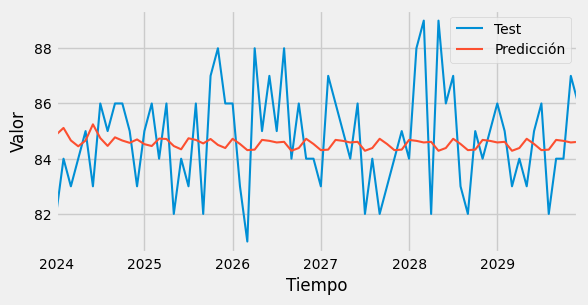

In [116]:
backtesting_forecasterAutoreg(df8_train,df8_test,32,36)

In [118]:
df9_train.index.freq='ME'
df9_test.index.freq='ME'

Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 15, 'n_estimators': 450}
  Backtesting metric: 0.08930998374345449



0.07207741349653426

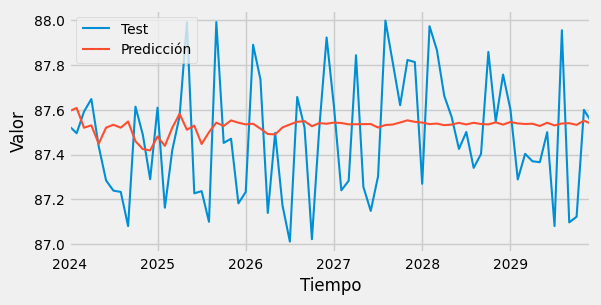

In [119]:
backtesting_forecasterAutoreg(df9_train,df9_test,32,36)

In [120]:
df10_train.index.freq='ME'
df10_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:263: UserWarning:

Feature 0 is constant and will be replaced with 0.



`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 0.0



0.0

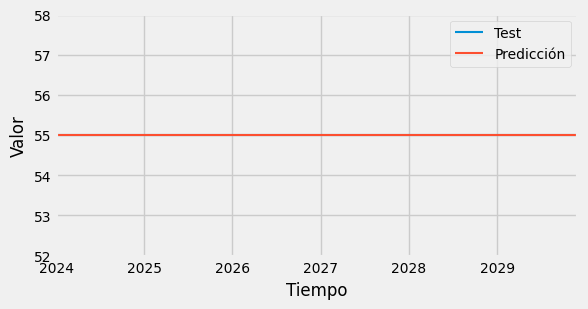

In [121]:
backtesting_forecasterAutoreg(df10_train,df10_test,32,36)

In [122]:
df11_train.index.freq='ME'
df11_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 175}
  Backtesting metric: 4.93237439918657



7.0661096782195445

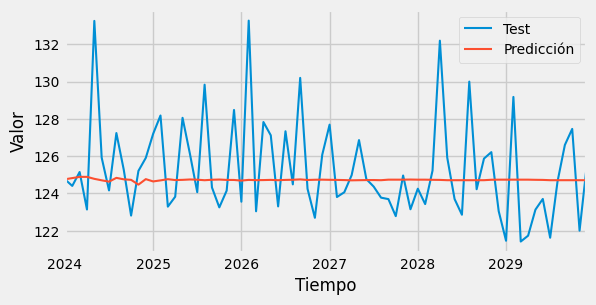

In [123]:
backtesting_forecasterAutoreg(df11_train,df11_test,32,36)

In [124]:
df12_train.index.freq='ME'
df12_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 5, 'n_estimators': 175}
  Backtesting metric: 1.8977399629699134



1.8371621235451248

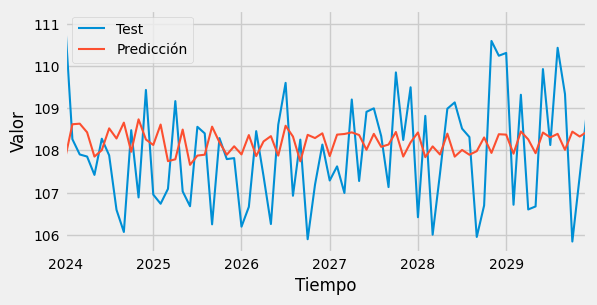

In [125]:
backtesting_forecasterAutoreg(df12_train,df12_test,32,36)

In [126]:
df13_train.index.freq='ME'
df13_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 250}
  Backtesting metric: 0.9575415343602943



1.169179977688855

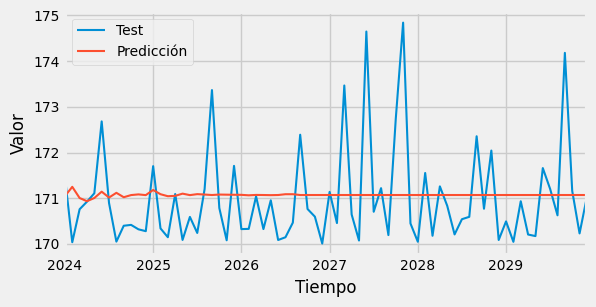

In [127]:
backtesting_forecasterAutoreg(df13_train,df13_test,32,36)

In [128]:
df14_train.index.freq='ME'
df14_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 450}
  Backtesting metric: 214.88556645883867



126.3877939843318

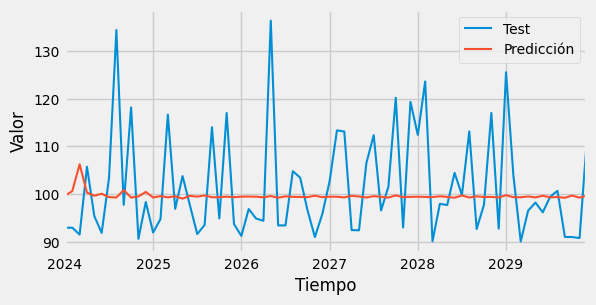

In [129]:
backtesting_forecasterAutoreg(df14_train,df14_test,32,36)

In [130]:
df15_train.index.freq='ME'
df15_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 15, 'n_estimators': 250}
  Backtesting metric: 1.308841715009225



1.1985773224702525

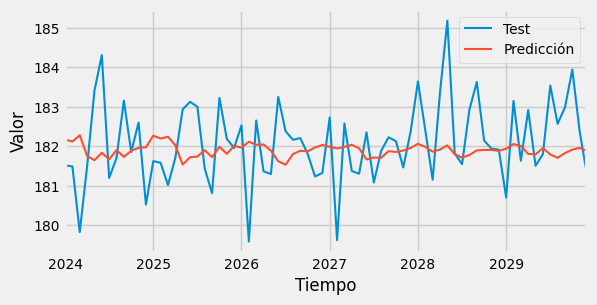

In [131]:
backtesting_forecasterAutoreg(df15_train,df15_test,32,36)

In [132]:
df16_train.index.freq='ME'
df16_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 250.56027791050047



197.09863628385335

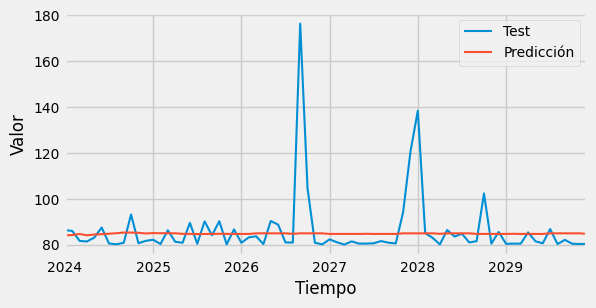

In [133]:
backtesting_forecasterAutoreg(df16_train,df16_test,32,36)

In [134]:
df17_train.index.freq='ME'
df17_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 16.96888700477272



9.47341320196402

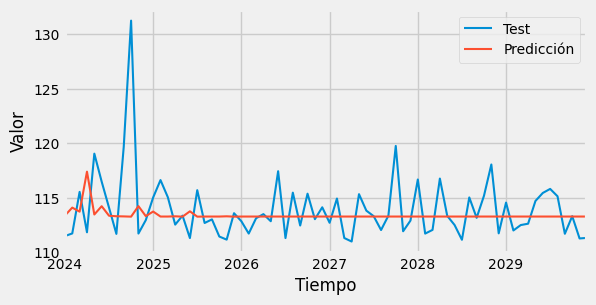

In [135]:
backtesting_forecasterAutoreg(df17_train,df17_test,32,36)

In [136]:
df18_train.index.freq='ME'
df18_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 20, 'n_estimators': 100}
  Backtesting metric: 47.25801600000078



71.97748266666693

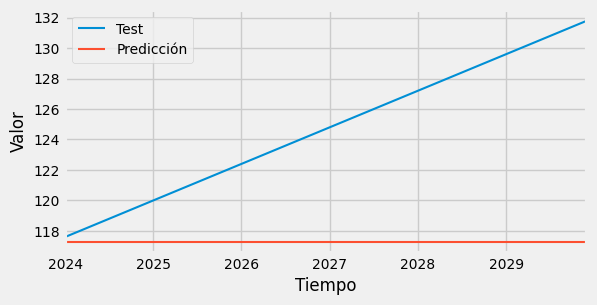

In [137]:
backtesting_forecasterAutoreg(df18_train,df18_test,32,36)

In [138]:
df19_train.index.freq='ME'
df19_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 20, 'n_estimators': 100}
  Backtesting metric: 425.32214400000294



458.00456622224425

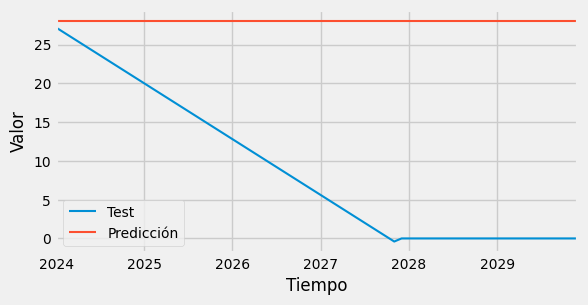

In [139]:
backtesting_forecasterAutoreg(df19_train,df19_test,32,36)

In [140]:
df20_train.index.freq='ME'
df20_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 53.58975218563033



83.83924814724313

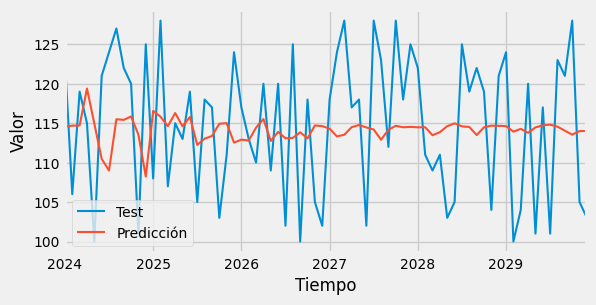

In [141]:
backtesting_forecasterAutoreg(df20_train,df20_test,32,36)

PERIODICOS

In [142]:
df21_train.index.freq='ME'
df21_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 1.4834432483204487e-24



1.458336652860416e-24

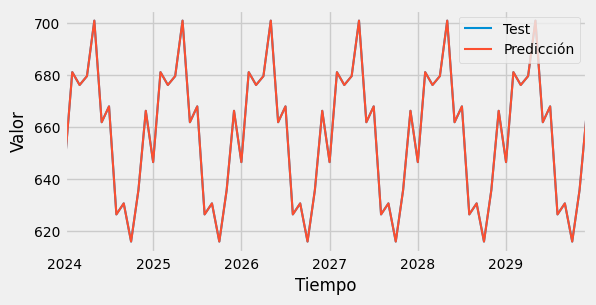

In [143]:
backtesting_forecasterAutoreg(df21_train,df21_test,32,36)

In [144]:
df22_train.index.freq='ME'
df22_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 15, 'n_estimators': 100}
  Backtesting metric: 1.1540863126110264e-24



1.1718392011167893e-24

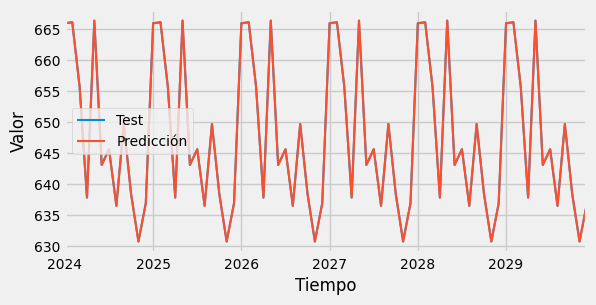

In [145]:
backtesting_forecasterAutoreg(df22_train,df22_test,32,36)

In [146]:
df23_train.index.freq='ME'
df23_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 20, 'n_estimators': 100}
  Backtesting metric: 8.153701135052608e-25



8.453110903889338e-25

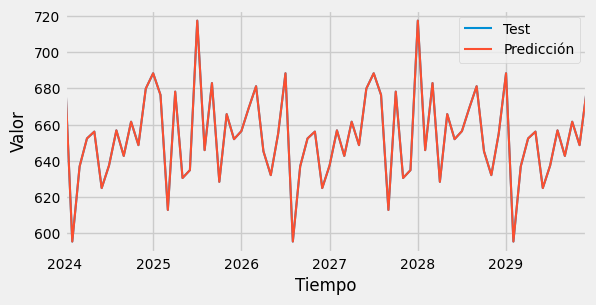

In [147]:
backtesting_forecasterAutoreg(df23_train,df23_test,32,36)

In [148]:
df24_train.index.freq='ME'
df24_test.index.freq='ME'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of models compared: 40.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 20, 'n_estimators': 100}
  Backtesting metric: 9.591016585205365e-25



0.001163257112113388

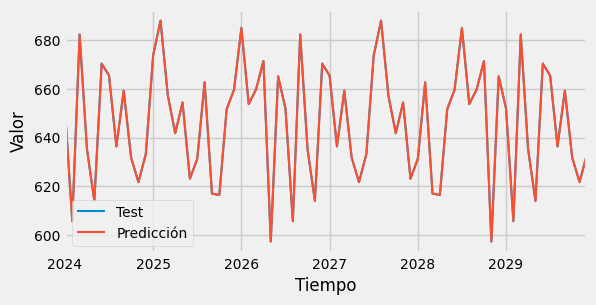

In [149]:
backtesting_forecasterAutoreg(df24_train,df24_test,32,36)

MODELOS ARMA

Number of models compared: 40.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 10, 'n_estimators': 250}
  Backtesting metric: 0.8630887121874026



0.9830741408653024

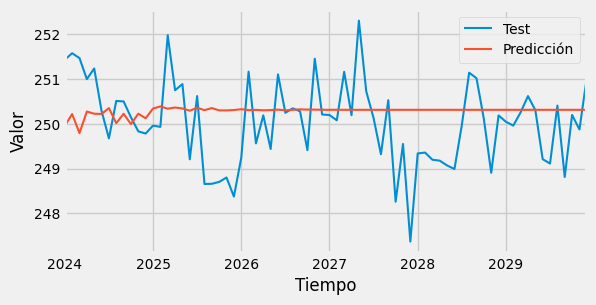

In [150]:
backtesting_forecasterAutoreg(df25_train,df25_test,32,36)

Number of models compared: 40.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 15, 'n_estimators': 450}
  Backtesting metric: 2.2551298850754713



2.3125837515116974

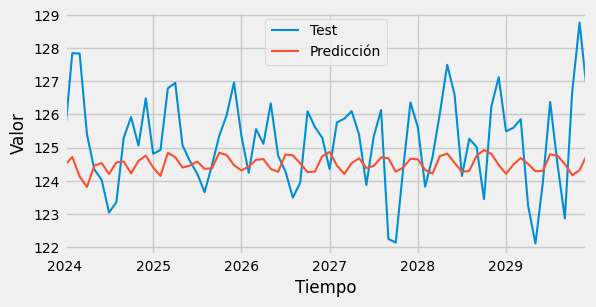

In [151]:
backtesting_forecasterAutoreg(df26_train,df26_test,32,36)

Number of models compared: 40.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 10, 'n_estimators': 175}
  Backtesting metric: 3.9758631051815403



2.6961764025818145

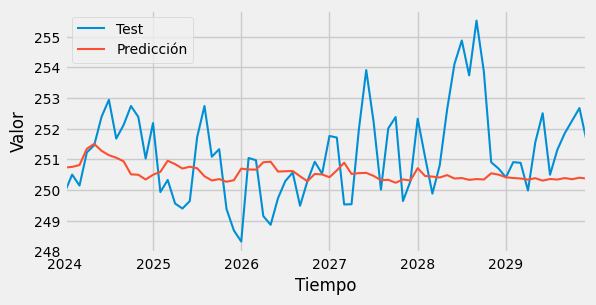

In [152]:
backtesting_forecasterAutoreg(df27_train,df27_test,32,36)

Number of models compared: 40.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 5, 'n_estimators': 250}
  Backtesting metric: 0.7910113598283387



0.8377287340075578

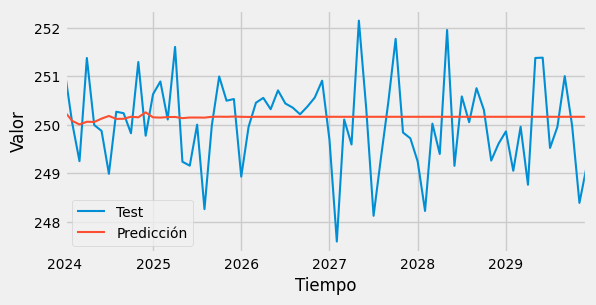

In [153]:
backtesting_forecasterAutoreg(df28_train,df28_test,32,36)

Number of models compared: 40.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 450}
  Backtesting metric: 1.935922559332522



1.771226258821109

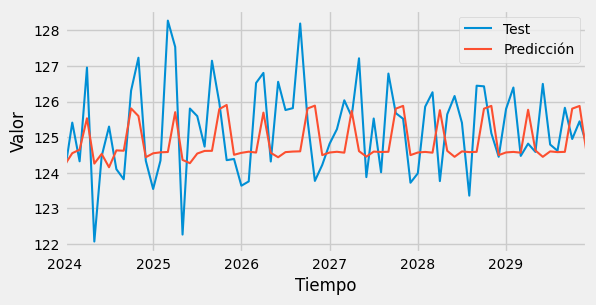

In [154]:
backtesting_forecasterAutoreg(df29_train,df29_test,32,36)

Number of models compared: 40.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 5, 'n_estimators': 450}
  Backtesting metric: 3.2545457804395146



3.1094288723007195

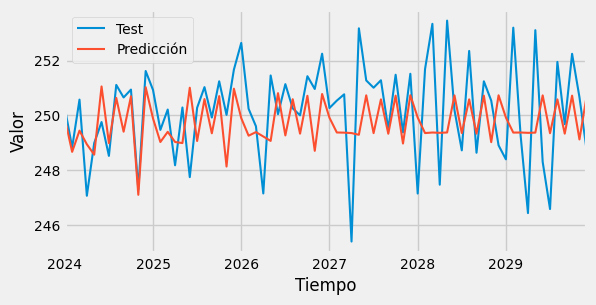

In [155]:
backtesting_forecasterAutoreg(df30_train,df30_test,32,36)

FORECASTER AUTOREG DIRECTO

In [156]:
from skforecast.exceptions import LongTrainingWarning
warnings.simplefilter('ignore', category=LongTrainingWarning)

In [157]:
def backtesting_forecasterAutoregDirect(datos_train,datos_test,steps,lags):

    forecaster = ForecasterAutoregDirect(
                regressor     = Ridge(random_state=123),
                transformer_y = StandardScaler(),
                steps         = steps,
                lags          = lags
             )

    # Valores candidatos de lags
    lags_grid = [5, 12, 20]

    # Valores candidatos de hiperparámetros del regresor
    param_grid = {'alpha': np.logspace(-5, 5, 10)}

    resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train[datos_train.columns[0]],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.8),
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False
                    )

    # Predicciones
    # ==============================================================================
    predicciones = forecaster.predict()

    # Error de test
    # ==============================================================================
    error_mse = mean_squared_error(
                    y_true = datos_test,
                    y_pred = predicciones
                )

    fig, ax = plt.subplots(figsize=(6, 3))
    pred = predicciones.to_frame()

    datos_test = datos_test.rename(columns={datos_test.columns[0]: 'Test'})
    datos_test.plot(ax=ax,label='Valores Reales')

    pred = pred.rename(columns={pred.columns[0]: 'Predicción'})
    pred.plot(ax=ax,label='Predicción')

    ax.set_xlabel('Tiempo')
    ax.set_ylabel(datos_train.columns[0])

    return error_mse

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'alpha': 0.2782559402207126}
  Backtesting metric: 0.0029261199097129907



0.003561364206368383

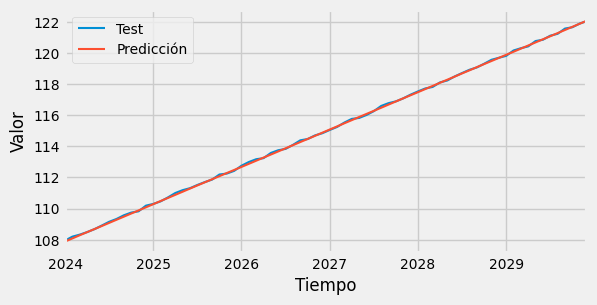

In [158]:
backtesting_forecasterAutoregDirect(df1_train,df1_test,72,20)

Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'alpha': 0.0001291549665014884}
  Backtesting metric: 83564715882504.84



307153104551190.5

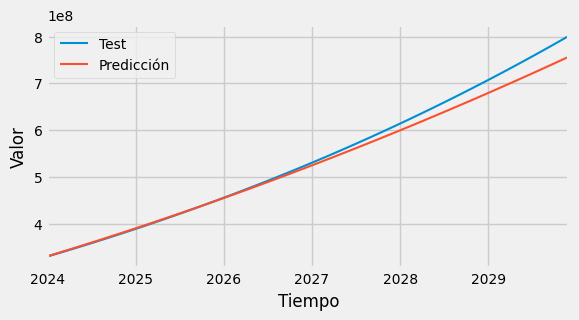

In [162]:
backtesting_forecasterAutoregDirect(df2_train,df2_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 0.0001291549665014884}
  Backtesting metric: 1.0973819018178592e-13



4.3066416072164505e-14

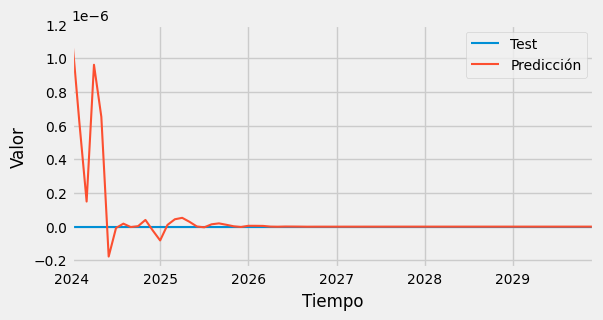

In [163]:
backtesting_forecasterAutoregDirect(df3_train,df3_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 1e-05}
  Backtesting metric: 2.764508852030043e-05



2.2748104100991143e-05

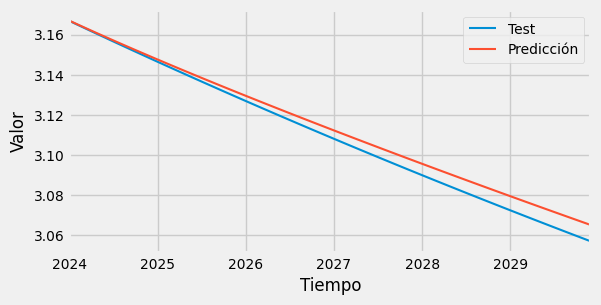

In [164]:
backtesting_forecasterAutoregDirect(df4_train,df4_test,72,20)

DISTRIBUCIONES

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'alpha': 1e-05}
  Backtesting metric: 15.792686371471259



23.9695563377157

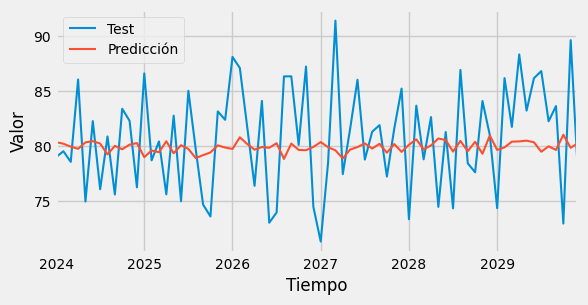

In [165]:
backtesting_forecasterAutoregDirect(df5_train,df5_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 100000.0}
  Backtesting metric: 6.32617089025434



6.408514392559149

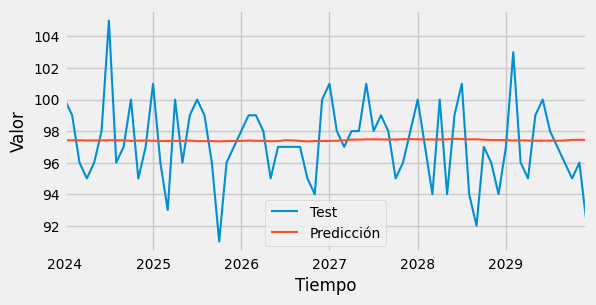

In [166]:
backtesting_forecasterAutoregDirect(df6_train,df6_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'alpha': 100000.0}
  Backtesting metric: 6.767568818929195



8.647276453447724

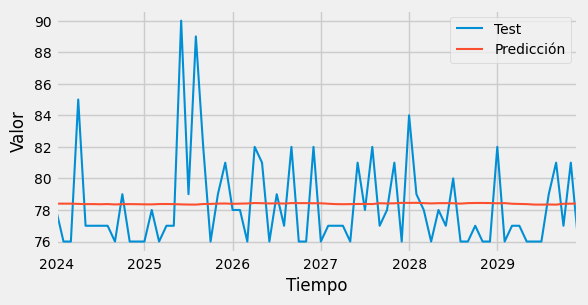

In [167]:
backtesting_forecasterAutoregDirect(df7_train,df7_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 599.4842503189421}
  Backtesting metric: 6.144559854243997



6.73275926267348

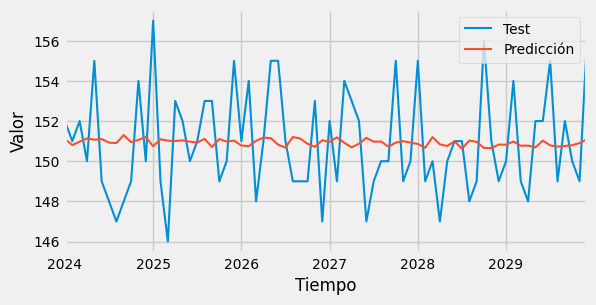

In [168]:
backtesting_forecasterAutoregDirect(dfg_train,dfg_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'alpha': 7742.636826811277}
  Backtesting metric: 3.1813598856178604



3.400487094637688

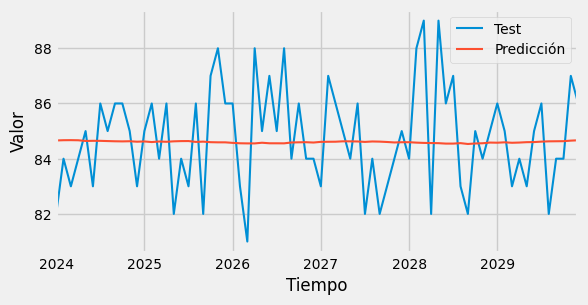

In [169]:
backtesting_forecasterAutoregDirect(df8_train,df8_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 599.4842503189421}
  Backtesting metric: 0.08385657770539719



0.07541915281930327

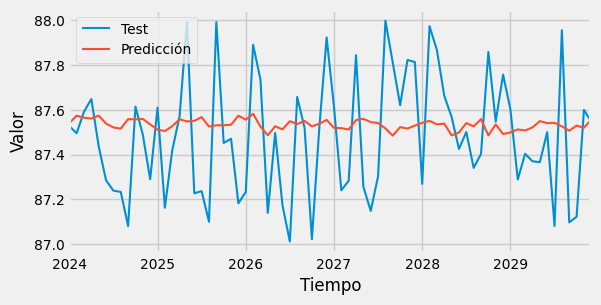

In [170]:
backtesting_forecasterAutoregDirect(df9_train,df9_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'alpha': 1e-05}
  Backtesting metric: 0.0



0.0

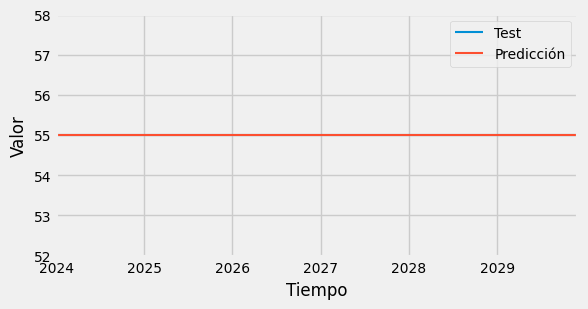

In [171]:
backtesting_forecasterAutoregDirect(df10_train,df10_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 100000.0}
  Backtesting metric: 4.90235483962237



6.722183459244881

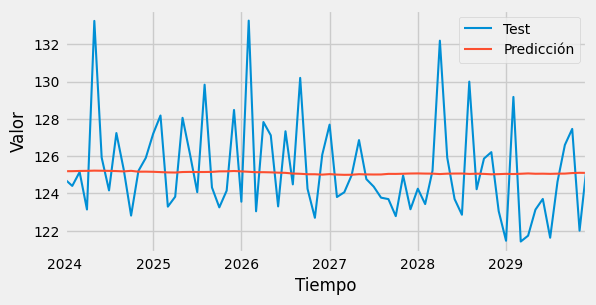

In [172]:
backtesting_forecasterAutoregDirect(df11_train,df11_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'alpha': 100000.0}
  Backtesting metric: 1.9554486606020667



1.6786892997652787

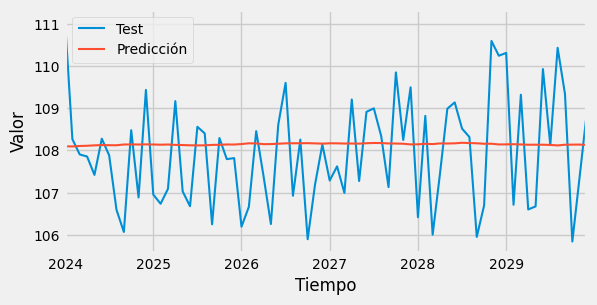

In [173]:
backtesting_forecasterAutoregDirect(df12_train,df12_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'alpha': 599.4842503189421}
  Backtesting metric: 0.9470294750770762



1.1855125593708706

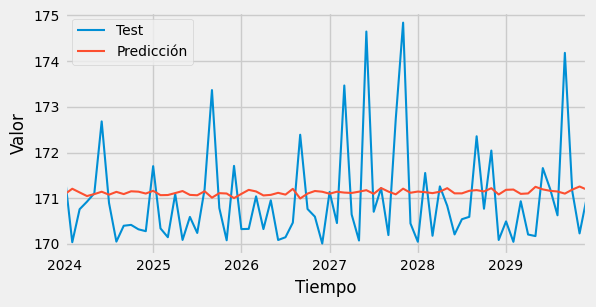

In [174]:
backtesting_forecasterAutoregDirect(df13_train,df13_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'alpha': 7742.636826811277}
  Backtesting metric: 213.14851186718332



120.19358936054722

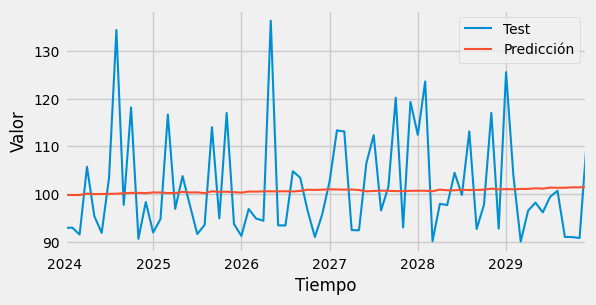

In [175]:
backtesting_forecasterAutoregDirect(df14_train,df14_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'alpha': 100000.0}
  Backtesting metric: 1.4067014827957824



1.058815774208635

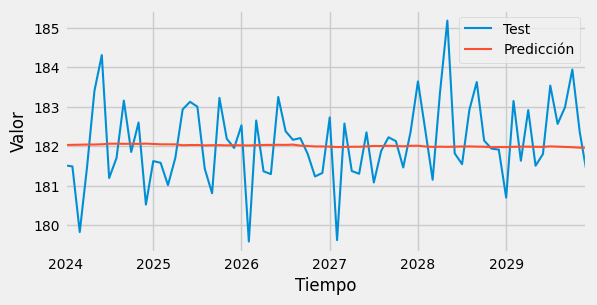

In [176]:
backtesting_forecasterAutoregDirect(df15_train,df15_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'alpha': 599.4842503189421}
  Backtesting metric: 261.6468601669981



209.13186396137982

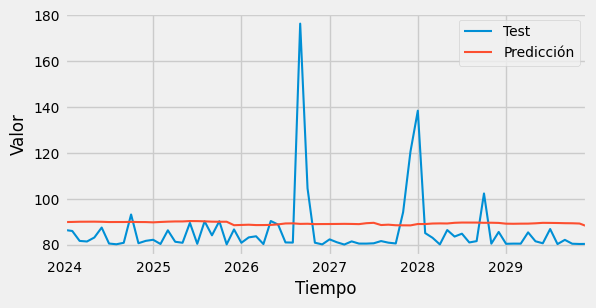

In [177]:
backtesting_forecasterAutoregDirect(df16_train,df16_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'alpha': 100000.0}
  Backtesting metric: 16.65400216134917



8.945971673969593

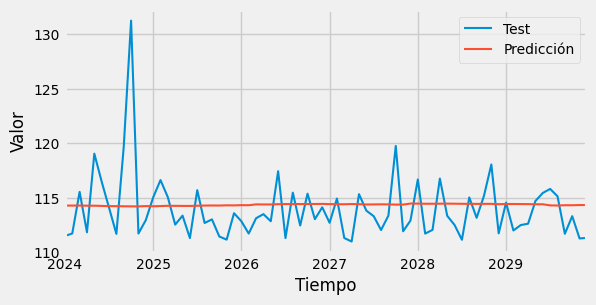

In [178]:
backtesting_forecasterAutoregDirect(df17_train,df17_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 1e-05}
  Backtesting metric: 7.714171646917012e-14



3.401591605385685e-14

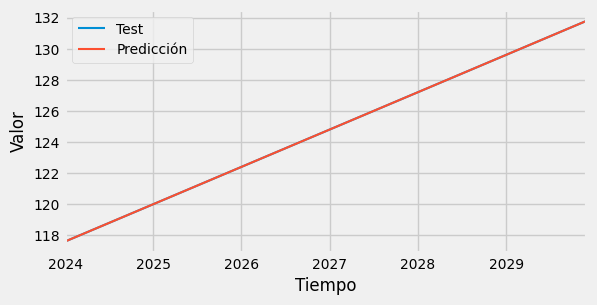

In [179]:
backtesting_forecasterAutoregDirect(df18_train,df18_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 1e-05}
  Backtesting metric: 6.942758071255019e-13



29.84721907146583

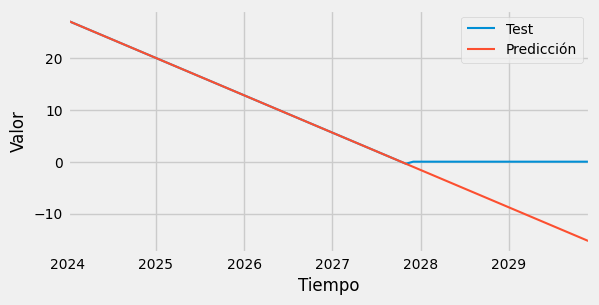

In [180]:
backtesting_forecasterAutoregDirect(df19_train,df19_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'alpha': 599.4842503189421}
  Backtesting metric: 58.49153319158676



78.43690074999547

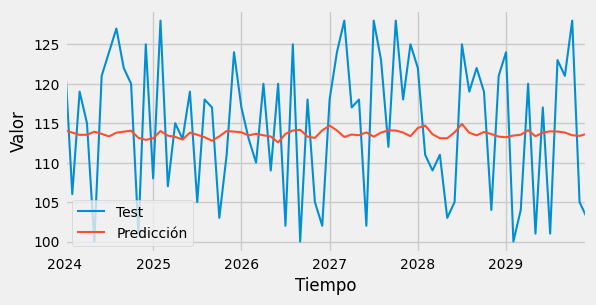

In [181]:
backtesting_forecasterAutoregDirect(df20_train,df20_test,72,20)

MODELOS PERIÓDICOS

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 1e-05}
  Backtesting metric: 1.1853497391324109e-11



5.143066099317511e-12

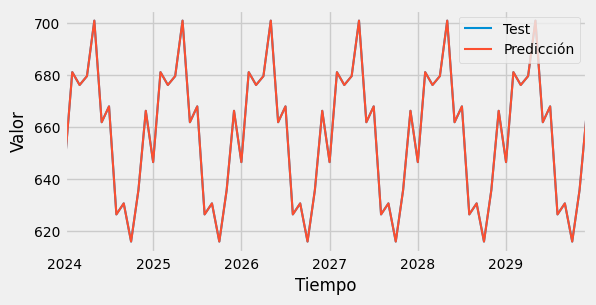

In [182]:
backtesting_forecasterAutoregDirect(df21_train,df21_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 1e-05}
  Backtesting metric: 1.359398466372292e-12



5.43215735156301e-13

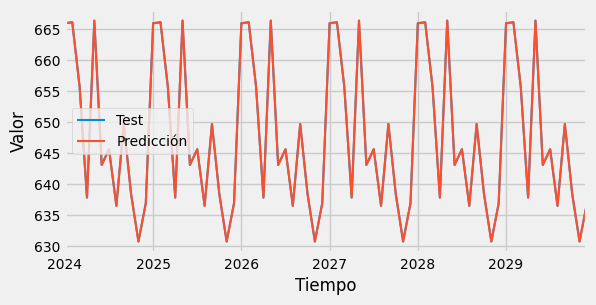

In [183]:
backtesting_forecasterAutoregDirect(df22_train,df22_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 3.593813663804626}
  Backtesting metric: 52.16032413344409



224.5535460971874

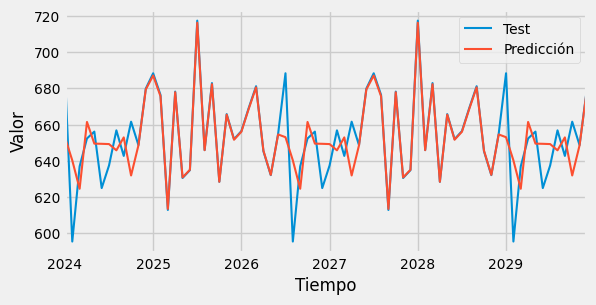

In [184]:
backtesting_forecasterAutoregDirect(df23_train,df23_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 3.593813663804626}
  Backtesting metric: 46.89214388807089



45.37943320989413

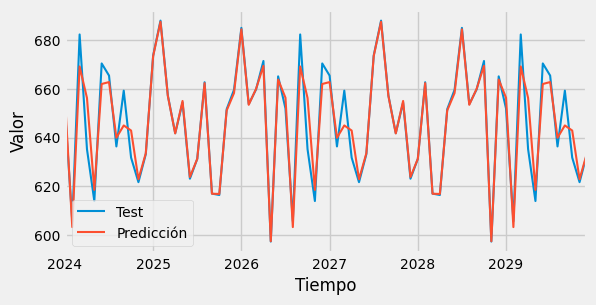

In [185]:
backtesting_forecasterAutoregDirect(df24_train,df24_test,72,20)

MODELOS ARMA

Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'alpha': 100000.0}
  Backtesting metric: 0.8187844743489581



0.8962931770196527

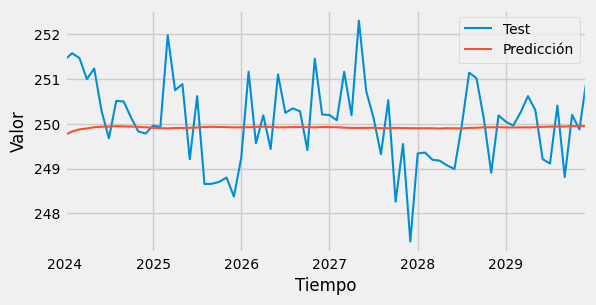

In [186]:
backtesting_forecasterAutoregDirect(df25_train,df25_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'alpha': 7742.636826811277}
  Backtesting metric: 1.9759757209829862



1.9418836495949021

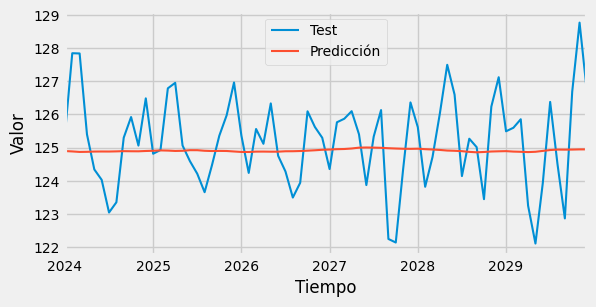

In [187]:
backtesting_forecasterAutoregDirect(df26_train,df26_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 599.4842503189421}
  Backtesting metric: 3.81671578957157



3.802397194630019

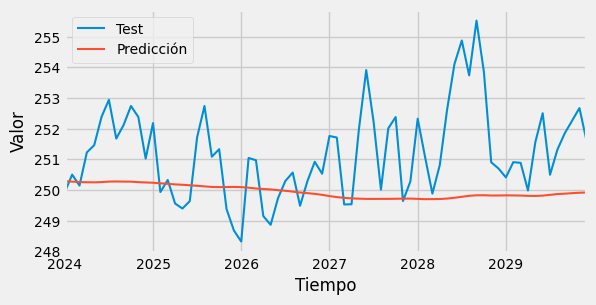

In [189]:
backtesting_forecasterAutoregDirect(df27_train,df27_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'alpha': 3.593813663804626}
  Backtesting metric: 0.7156928278457573



1.150902749028275

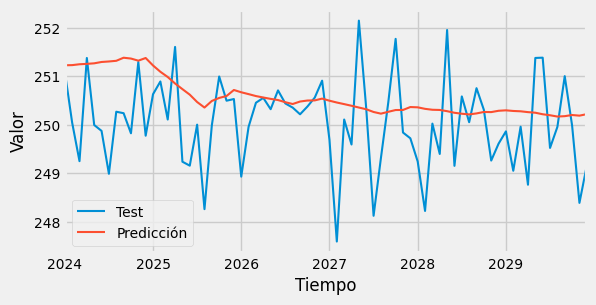

In [188]:
backtesting_forecasterAutoregDirect(df28_train,df28_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 1.8167706011658278



1.727714125292029

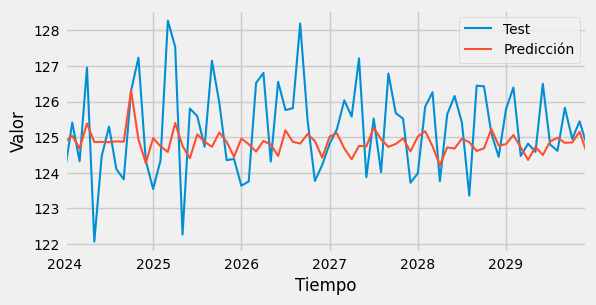

In [190]:
backtesting_forecasterAutoregDirect(df29_train,df29_test,72,20)

Number of models compared: 30.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 1e-05}
  Backtesting metric: 3.8501570968843466



2.7072626205276618

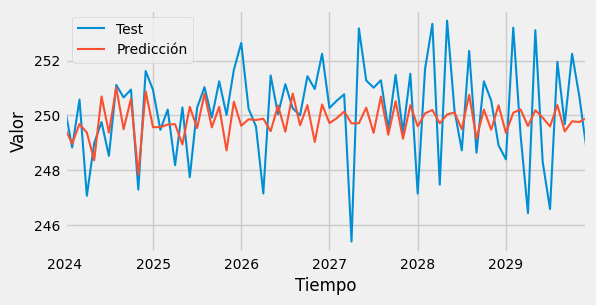

In [191]:
backtesting_forecasterAutoregDirect(df30_train,df30_test,72,20)

RNN con recurrent layer RNN

In [159]:
def rnn_2 (data_train,levels,steps,lags):
    model = create_and_compile_model(
        series=data_train,
        levels=levels,
        lags=lags,
        steps=steps,
        recurrent_layer="RNN",
        recurrent_units=4,
        dense_units=16,
        optimizer=Adam(learning_rate=0.01),
        loss=MeanSquaredError()
    )
    return model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [160]:
def forecaster_rnn_2(data_train,levels,steps,lags,epochs,batch_size,data_val):
    forecaster = ForecasterRnn(
        regressor=rnn_2(data_train,levels,steps,lags),
        levels=levels,
        transformer_series=MinMaxScaler(),
        fit_kwargs={
            "epochs": epochs,
            "batch_size": batch_size,
            "callbacks": [
                EarlyStopping(monitor="val_loss", patience=5)
            ],
            "series_val": data_val,
        },
    )
    forecaster.fit(data_train)
    return forecaster

In [223]:
def backtesting_rnn_2(data,data_train,data_val,levels,steps,lags,epochs,batch_size,end_validation):

    forecaster = forecaster_rnn_2(data_train,levels,steps,lags,epochs,batch_size,data_val)
    metrics, predictions = backtesting_forecaster_multiseries(
        forecaster=forecaster,
        steps=forecaster.max_step,
        series=data,
        levels=forecaster.levels,
        initial_train_size=len(data_train),
        metric='mean_squared_error',
        verbose=False,
        refit=False,
    )

    fig, ax = plt.subplots(figsize=(6, 3))

    data_val = data_val.rename(columns={data_val.columns[0]: 'Test'})
    data_val.plot(ax=ax,label='Valores Reales')

    predictions = predictions.rename(columns={predictions.columns[0]: 'Predicción'})
    predictions.plot(ax=ax,label='Predicción')

    ax.set_xlabel('Tiempo')
    ax.set_ylabel(data.columns[0])

    plt.legend()
    plt.show()
    return metrics.loc[0, 'mean_squared_error']

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.2518 - val_loss: 0.0447
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0412 - val_loss: 0.0126
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0167 - val_loss: 0.0287
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0077 - val_loss: 0.0105
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - val_loss: 0.0185
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - val_loss: 0.0230
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - val_loss: 0.0184
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.0528e-04 - val_loss: 0.0143
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 4.0345e-04 - val_loss: 0.0145
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3425e-04 - val_loss: 0.0156
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4021e-04 - val_loss: 0.0164
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.2063e-04 - val_loss: 0.0160
Epoch 5/8
9/9 

  0%|          | 0/8 [00:00<?, ?it/s]

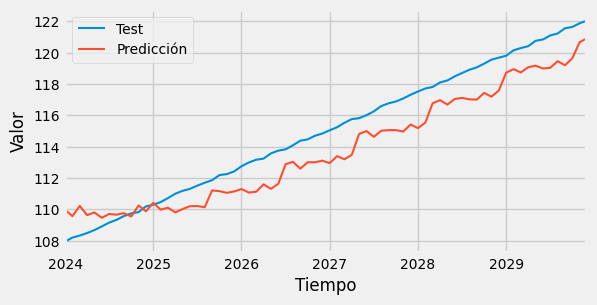

2.4351391190760694

In [224]:
backtesting_rnn_2(df1,df1_train,df1_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0934 - val_loss: 0.2762
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0757 - val_loss: 0.2086
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0674 - val_loss: 0.1728
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0615 - val_loss: 0.1592
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0666 - val_loss: 0.1610
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0663 - val_loss: 0.1693
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0720 - val_loss: 0.1751
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0617 - val_loss: 0.1770
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0617 - val_loss: 0.1727
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0642 - val_loss: 0.1735
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0673 - val_loss: 0.1747
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0638 - val_loss: 0.1754
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

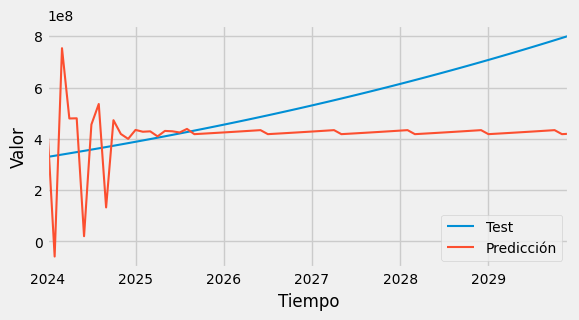

3.962048863251966e+16

In [225]:
backtesting_rnn_2(df2,df2_train,df2_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 2.1656e-05 - val_loss: 1.1883e-05
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.7993e-06 - val_loss: 3.4162e-06
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9192e-06 - val_loss: 9.4070e-07
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.4802e-07 - val_loss: 7.0993e-07
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1772e-07 - val_loss: 3.4398e-07
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0059e-07 - val_loss: 1.2172e-07
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3355e-07 - val_loss: 4.9081e-08
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0157e-07 - val_loss: 1.4843e-08
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 1.1962e-07 - val_loss: 4.5600e-08
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.0861e-08 - val_loss: 7.0567e-08
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4122e-07 - val_loss: 1.9005e-08
Epoch 4/8
9/9 ━━━━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

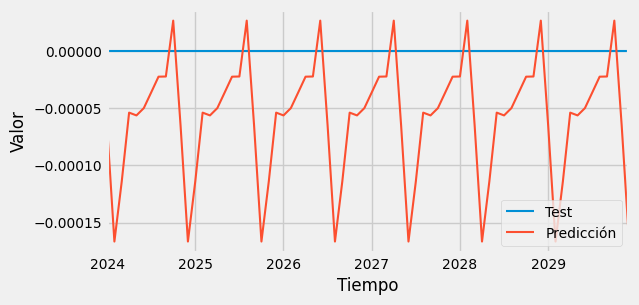

5.955425207975609e-09

In [226]:
backtesting_rnn_2(df3,df3_train,df3_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0235 - val_loss: 0.0629
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102 - val_loss: 0.0438
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0093 - val_loss: 0.0301
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0060 - val_loss: 0.0166
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 0.0095
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - val_loss: 0.0097
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.1145e-04 - val_loss: 0.0051
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1980e-04 - val_loss: 0.0029
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 7.8591e-05 - val_loss: 0.0038
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.9541e-05 - val_loss: 0.0044
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.4844e-05 - val_loss: 0.0038
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3619e-05 - val_loss: 0.0035
Epoch 5/

  0%|          | 0/8 [00:00<?, ?it/s]

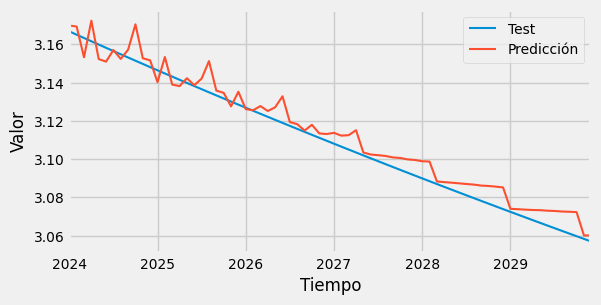

4.718933436621563e-05

In [227]:
backtesting_rnn_2(df4,df4_train,df4_test,[columna],10,20,8,30,144)

DISTRIBUCIONES

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.2615 - val_loss: 0.0965
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0597 - val_loss: 0.0846
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0459 - val_loss: 0.0765
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0432 - val_loss: 0.0725
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0408 - val_loss: 0.0701
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0382 - val_loss: 0.0687
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0378 - val_loss: 0.0680
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0378 - val_loss: 0.0669
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0386 - val_loss: 0.0662
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0362 - val_loss: 0.0660
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0375 - val_loss: 0.0653
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0366 - val_loss: 0.0650
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

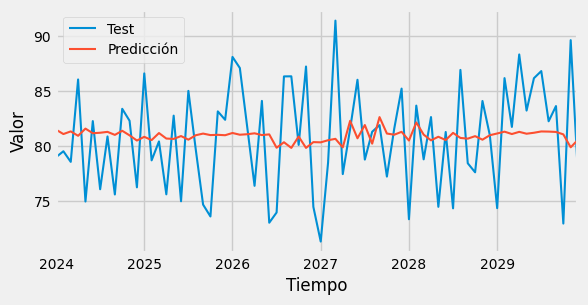

22.87262470576067

In [228]:
backtesting_rnn_2(df5,df5_train,df5_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.4382 - val_loss: 0.0817
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0816 - val_loss: 0.0503
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0430 - val_loss: 0.0363
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0357 - val_loss: 0.0352
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0334 - val_loss: 0.0323
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0326 - val_loss: 0.0329
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0324 - val_loss: 0.0317
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0313 - val_loss: 0.0317
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0316 - val_loss: 0.0313
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0299 - val_loss: 0.0315
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0304 - val_loss: 0.0310
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0303 - val_loss: 0.0307
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0

  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:730: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.42857143 0.57142857 0.28571429 0.42857143 0.42857143 0.42857143
 0.21428571 0.57142857 0.57142857 0.28571429 0.42857143 0.35714286
 0.21428571 0.42857143 0.42857143 0.42857143 0.57142857 0.78571429
 0.57142857 0.28571429]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:730: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.42857143 0.35714286 0.21428571 0.42857143 0.42857143 0.42857143
 0.57142857 0.78571429 0.57142857 0.28571429 0.64285714 0.57142857
 0.35714286 0.28571429 0.35714286 0.5        1.         0.35714286
 0.42857143 0.64285714]' has dtype incompatible with int64, please explic

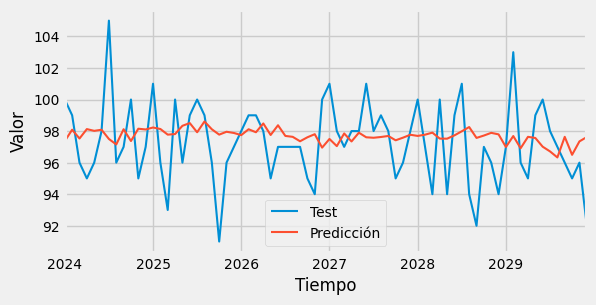

6.816770794280779

In [229]:
backtesting_rnn_2(df6,df6_train,df6_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0502 - val_loss: 0.0292
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0297 - val_loss: 0.0293
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0292 - val_loss: 0.0276
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0292 - val_loss: 0.0274
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0280 - val_loss: 0.0274
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0282 - val_loss: 0.0273
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0277 - val_loss: 0.0272
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0273 - val_loss: 0.0272
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0283 - val_loss: 0.0270
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0289 - val_loss: 0.0272
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0283 - val_loss: 0.0271
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0288 - val_loss: 0.0271
Epoch 5/8
9/9 ━━━━━━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:730: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21428571 0.07142857 0.42857143 0.         0.42857143 0.14285714
 0.28571429 0.         0.14285714 0.14285714 0.14285714 0.
 0.         0.         0.         0.5        0.         0.78571429
 0.14285714 0.07142857]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:730: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.14285714 0.         0.         0.         0.         0.5
 0.         0.78571429 0.14285714 0.07142857 0.14285714 0.
 0.         0.64285714 0.07142857 0.07142857 0.07142857 0.07142857
 0.         0.21428571]' has dtype incompatible with int64, please explicitly cast to a compatib

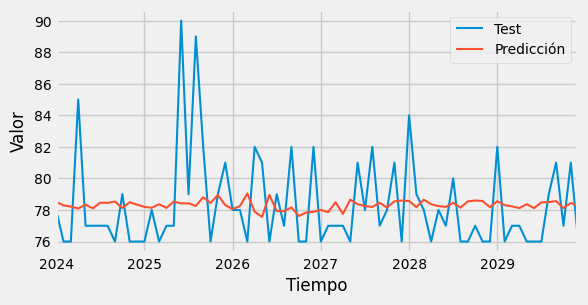

8.741851716751828

In [230]:
backtesting_rnn_2(df7,df7_train,df7_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1335 - val_loss: 0.0853
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0490 - val_loss: 0.0569
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0346 - val_loss: 0.0550
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0337 - val_loss: 0.0536
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0329 - val_loss: 0.0535
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0330 - val_loss: 0.0533
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0318 - val_loss: 0.0527
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0310 - val_loss: 0.0525
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0308 - val_loss: 0.0524
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0318 - val_loss: 0.0525
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0312 - val_loss: 0.0521
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0316 - val_loss: 0.0523
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:730: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.45454545 0.36363636 0.36363636 0.18181818 0.63636364 0.27272727
 0.36363636 0.54545455 0.18181818 0.54545455 0.72727273 0.09090909
 0.36363636 0.45454545 0.54545455 0.72727273 0.27272727 0.27272727
 0.27272727 0.72727273]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:730: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.72727273 0.09090909 0.36363636 0.45454545 0.54545455 0.72727273
 0.27272727 0.27272727 0.27272727 0.72727273 0.54545455 0.45454545
 0.54545455 0.36363636 0.81818182 0.27272727 0.18181818 0.09090909
 0.18181818 0.27272727]' has dtype incompatible with int64, please explic

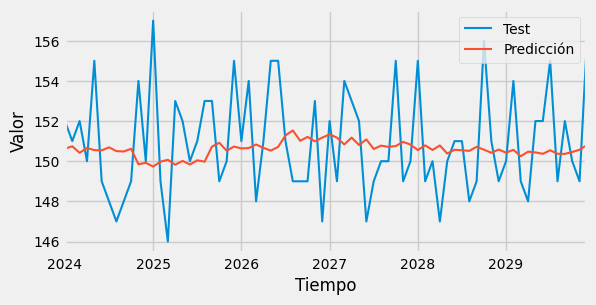

7.090781916453529

In [231]:
backtesting_rnn_2(dfg,dfg_train,dfg_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.2943 - val_loss: 0.1430
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1075 - val_loss: 0.0741
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0518 - val_loss: 0.0730
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0439 - val_loss: 0.0619
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0418 - val_loss: 0.0605
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0403 - val_loss: 0.0621
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0402 - val_loss: 0.0604
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0389 - val_loss: 0.0605
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0388 - val_loss: 0.0604
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0383 - val_loss: 0.0599
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0377 - val_loss: 0.0606
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0369 - val_loss: 0.0603
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:730: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.125 0.5   0.5   0.5   0.25  0.625 0.875 0.375 0.875 0.25  0.    0.375
 0.5   0.5   0.625 0.375 0.625 0.25  0.625 0.5  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:730: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.    0.375 0.5   0.5   0.625 0.375 0.625 0.25  0.625 0.5   0.125 0.375
 0.25  0.375 0.5   0.25  0.625 0.5   0.625 0.625]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:730: FutureWarning:

Setting an item of incompatible dtype is deprecated and will 

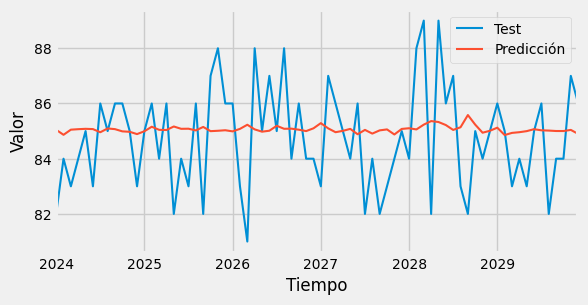

3.509798011263936

In [232]:
backtesting_rnn_2(df8,df8_train,df8_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.4474 - val_loss: 0.2447
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2551 - val_loss: 0.1669
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1681 - val_loss: 0.1107
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1153 - val_loss: 0.0869
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0946 - val_loss: 0.0836
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0900 - val_loss: 0.0803
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0873 - val_loss: 0.0792
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0863 - val_loss: 0.0789
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0853 - val_loss: 0.0786
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0858 - val_loss: 0.0784
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0822 - val_loss: 0.0785
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0856 - val_loss: 0.0784
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

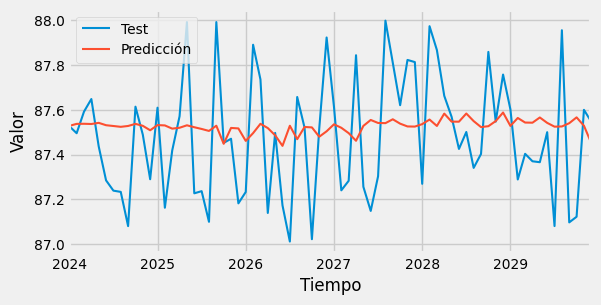

0.07377349540353213

In [233]:
backtesting_rnn_2(df9,df9_train,df9_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00


  0%|          | 0/8 [00:00<?, ?it/s]

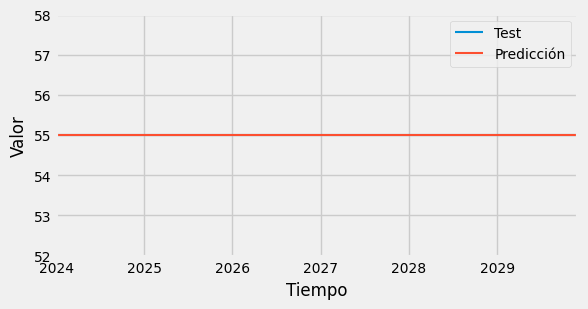

0.0

In [234]:
backtesting_rnn_2(df10,df10_train,df10_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1451 - val_loss: 0.0704
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0737 - val_loss: 0.0531
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0485 - val_loss: 0.0511
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0460 - val_loss: 0.0525
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0460 - val_loss: 0.0501
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0454 - val_loss: 0.0502
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0468 - val_loss: 0.0501
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0457 - val_loss: 0.0495
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0458 - val_loss: 0.0502
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0437 - val_loss: 0.0506
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0443 - val_loss: 0.0497
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0453 - val_loss: 0.0501
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

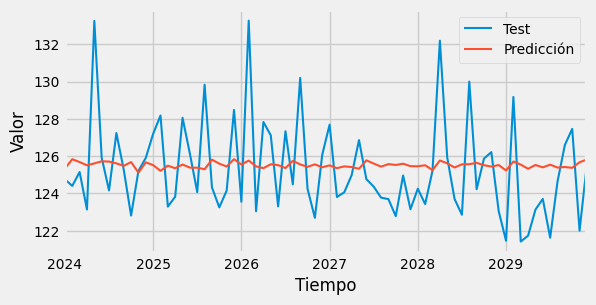

6.6831644688316425

In [235]:
backtesting_rnn_2(df11,df11_train,df11_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.2211 - val_loss: 0.1143
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0886 - val_loss: 0.0901
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0634 - val_loss: 0.0710
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0506 - val_loss: 0.0660
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0478 - val_loss: 0.0652
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0449 - val_loss: 0.0656
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0457 - val_loss: 0.0650
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0464 - val_loss: 0.0649
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0447 - val_loss: 0.0650
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0455 - val_loss: 0.0650
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0449 - val_loss: 0.0650
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0453 - val_loss: 0.0650
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0

  0%|          | 0/8 [00:00<?, ?it/s]

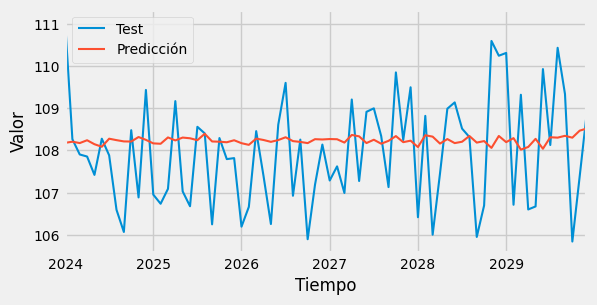

1.7152378757264162

In [236]:
backtesting_rnn_2(df12,df12_train,df12_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.1239 - val_loss: 0.0731
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0420 - val_loss: 0.0663
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0389 - val_loss: 0.0639
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0378 - val_loss: 0.0628
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0349 - val_loss: 0.0625
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0362 - val_loss: 0.0622
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0357 - val_loss: 0.0619
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0357 - val_loss: 0.0615
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0349 - val_loss: 0.0615
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0364 - val_loss: 0.0613
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0349 - val_loss: 0.0612
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0358 - val_loss: 0.0611
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

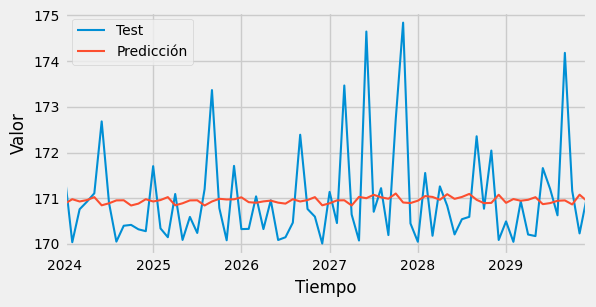

1.1774876790677404

In [237]:
backtesting_rnn_2(df13,df13_train,df13_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0353 - val_loss: 0.0681
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0242 - val_loss: 0.0703
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0216 - val_loss: 0.0698
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0231 - val_loss: 0.0688
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0212 - val_loss: 0.0693
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0217 - val_loss: 0.0690
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0210 - val_loss: 0.0690
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0221 - val_loss: 0.0684
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0214 - val_loss: 0.0697
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0231 - val_loss: 0.0689
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0235 - val_loss: 0.0695


  0%|          | 0/8 [00:00<?, ?it/s]

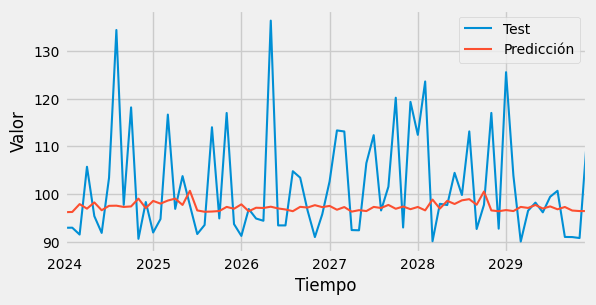

139.25183569555534

In [238]:
backtesting_rnn_2(df14,df14_train,df14_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.2872 - val_loss: 0.0987
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0975 - val_loss: 0.0420
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0282 - val_loss: 0.0448
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0236 - val_loss: 0.0417
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0221 - val_loss: 0.0398
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0198 - val_loss: 0.0391
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0205 - val_loss: 0.0380
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0189 - val_loss: 0.0391
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0188 - val_loss: 0.0378
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0189 - val_loss: 0.0393
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0184 - val_loss: 0.0374
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0183 - val_loss: 0.0390
Epoch 5/8
9/9 ━━━━━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

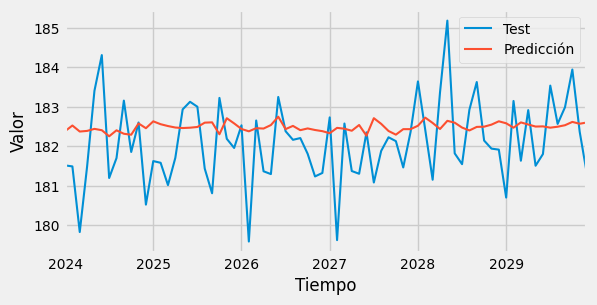

1.2046630668511926

In [239]:
backtesting_rnn_2(df15,df15_train,df15_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0115 - val_loss: 0.0360
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0113 - val_loss: 0.0367
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0111 - val_loss: 0.0361
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0121 - val_loss: 0.0361
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0082 - val_loss: 0.0365
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0104 - val_loss: 0.0359
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0094 - val_loss: 0.0364
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0097 - val_loss: 0.0361
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0081 - val_loss: 0.0363
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0099 - val_loss: 0.0361
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0109 - val_loss: 0.0365
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0091 - val_loss: 0.0361
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

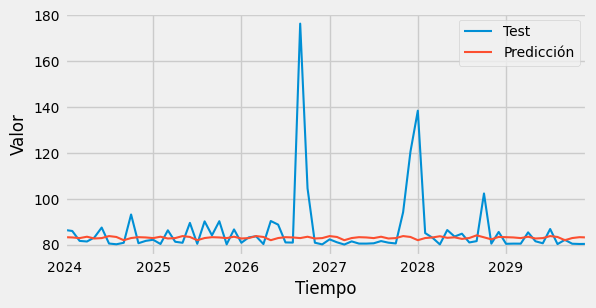

207.1887377339147

In [240]:
backtesting_rnn_2(df16,df16_train,df16_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0173 - val_loss: 0.0142
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0118 - val_loss: 0.0132
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0106 - val_loss: 0.0144
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0132 - val_loss: 0.0145
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0106 - val_loss: 0.0144
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0116 - val_loss: 0.0138
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0118 - val_loss: 0.0144
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114 - val_loss: 0.0146
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0119 - val_loss: 0.0144
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0125 - val_loss: 0.0142


  0%|          | 0/8 [00:00<?, ?it/s]

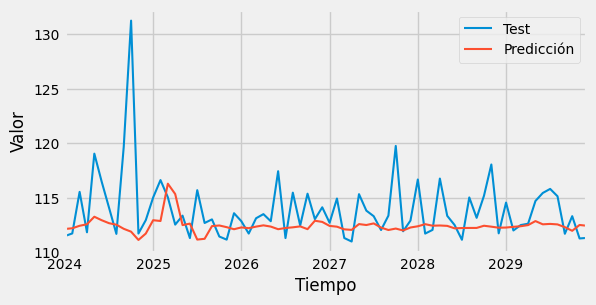

11.242319402862364

In [241]:
backtesting_rnn_2(df17,df17_train,df17_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1.9320 - val_loss: 0.2965
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1888 - val_loss: 0.1138
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0651 - val_loss: 0.0506
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0296 - val_loss: 0.0245
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0157 - val_loss: 0.0157
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - val_loss: 0.0136
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - val_loss: 0.0117
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0054 - val_loss: 0.0109
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0046 - val_loss: 0.0111
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - val_loss: 0.0113
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - val_loss: 0.0112
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - val_loss: 0.0111
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

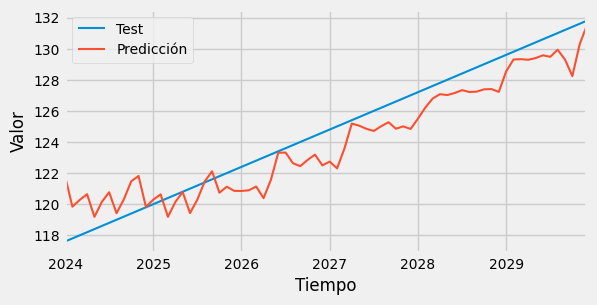

2.3113535400652836

In [242]:
backtesting_rnn_2(df18,df18_train,df18_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.1992 - val_loss: 0.0245
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0349 - val_loss: 0.0515
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0166 - val_loss: 0.0332
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0078 - val_loss: 0.0366
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0042 - val_loss: 0.0304
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023 - val_loss: 0.0228
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 0.0244
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.1987e-04 - val_loss: 0.0192
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 3.3723e-04 - val_loss: 0.0165
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1202e-04 - val_loss: 0.0166
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2947e-04 - val_loss: 0.0172
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.3991e-05 - val_loss: 0.0165
Epoch 5/

  0%|          | 0/8 [00:00<?, ?it/s]

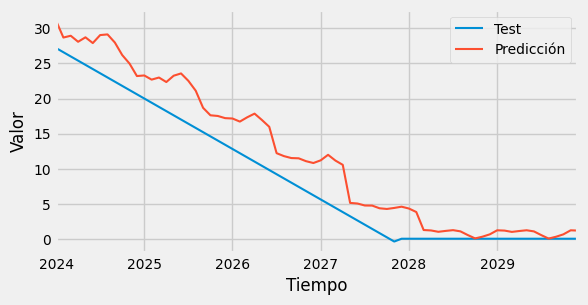

14.719018806641278

In [243]:
backtesting_rnn_2(df19,df19_train,df19_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.2842 - val_loss: 0.2951
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2112 - val_loss: 0.2280
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1567 - val_loss: 0.1789
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1196 - val_loss: 0.1461
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1027 - val_loss: 0.1262
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0900 - val_loss: 0.1152
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0849 - val_loss: 0.1097
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0824 - val_loss: 0.1070
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0827 - val_loss: 0.1060
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0830 - val_loss: 0.1056
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0832 - val_loss: 0.1056
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0824 - val_loss: 0.1056
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0

  0%|          | 0/8 [00:00<?, ?it/s]

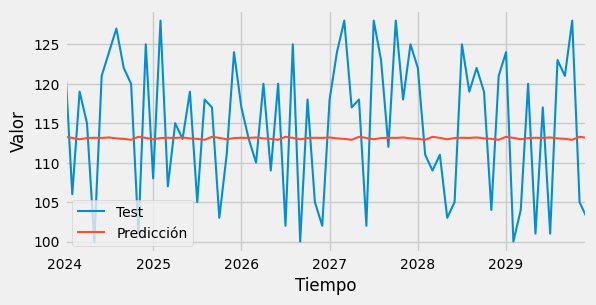

80.99437398311663

In [244]:
backtesting_rnn_2(df20,df20_train,df20_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.3043 - val_loss: 0.1729
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1486 - val_loss: 0.1037
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0943 - val_loss: 0.0781
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0784 - val_loss: 0.0716
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0696 - val_loss: 0.0648
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0629 - val_loss: 0.0591
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0558 - val_loss: 0.0521
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0506 - val_loss: 0.0444
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0424 - val_loss: 0.0368
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0357 - val_loss: 0.0257
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0248 - val_loss: 0.0219
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0202 - val_loss: 0.0171
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

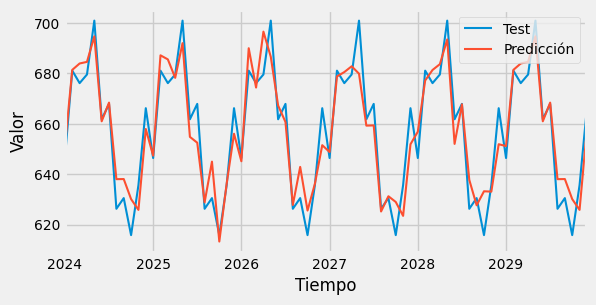

75.38684152697984

In [245]:
backtesting_rnn_2(df21,df21_train,df21_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.7843 - val_loss: 0.2424
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2137 - val_loss: 0.1475
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1366 - val_loss: 0.1219
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1212 - val_loss: 0.1172
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1170 - val_loss: 0.1118
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1116 - val_loss: 0.1083
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1066 - val_loss: 0.1049
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1063 - val_loss: 0.1014
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0994 - val_loss: 0.0984
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0966 - val_loss: 0.0963
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0973 - val_loss: 0.0948
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0940 - val_loss: 0.0934
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

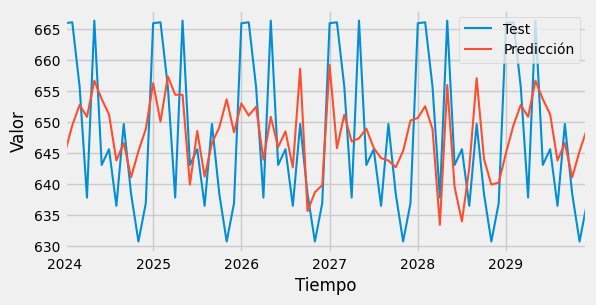

110.56036682445314

In [246]:
backtesting_rnn_2(df22,df22_train,df22_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.2553 - val_loss: 0.1715
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1622 - val_loss: 0.0928
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0907 - val_loss: 0.0590
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0581 - val_loss: 0.0459
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0456 - val_loss: 0.0413
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0427 - val_loss: 0.0414
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0428 - val_loss: 0.0419
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0423 - val_loss: 0.0415
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0429 - val_loss: 0.0412
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0431 - val_loss: 0.0412
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0418 - val_loss: 0.0411
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0430 - val_loss: 0.0411
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

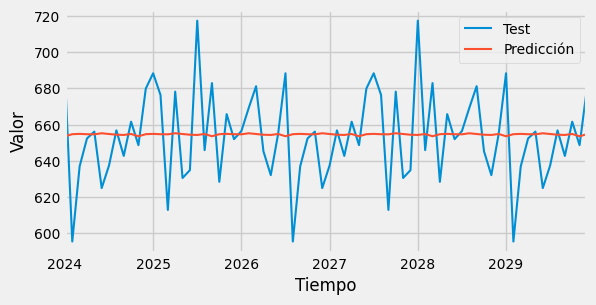

631.6248717078125

In [247]:
backtesting_rnn_2(df23,df23_train,df23_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.3374 - val_loss: 0.1742
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1443 - val_loss: 0.1121
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1018 - val_loss: 0.0962
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0886 - val_loss: 0.0911
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0844 - val_loss: 0.0847
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0774 - val_loss: 0.0815
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0733 - val_loss: 0.0794
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0721 - val_loss: 0.0778
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0724 - val_loss: 0.0767
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0710 - val_loss: 0.0759
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0696 - val_loss: 0.0753
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0685 - val_loss: 0.0746
Epoch 5/8
9/9 ━━━━━━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

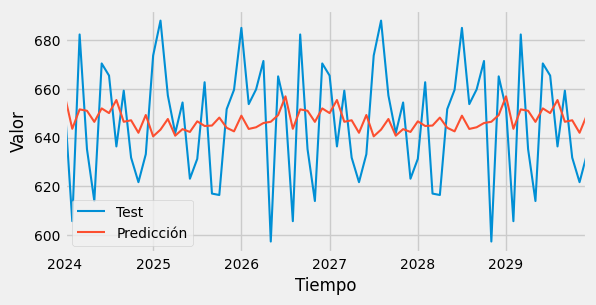

554.8860154287715

In [248]:
backtesting_rnn_2(df24,df24_train,df24_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.7878 - val_loss: 0.1186
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3165 - val_loss: 0.1198
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0882 - val_loss: 0.1545
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0136 - val_loss: 0.1063
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - val_loss: 0.1095
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054 - val_loss: 0.1234
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 0.1154
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0730e-04 - val_loss: 0.1103
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 3.4562e-04 - val_loss: 0.1155
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7650e-04 - val_loss: 0.1149
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.6365e-05 - val_loss: 0.1137
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.9441e-05 - val_loss: 0.1152
Epoch 5/8
9/9 

  0%|          | 0/8 [00:00<?, ?it/s]

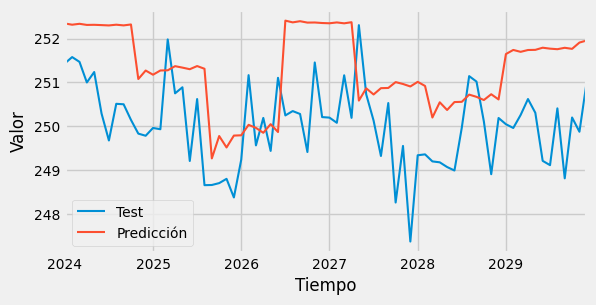

2.5844459552723693

In [249]:
backtesting_rnn_2(df25,df25_train,df25_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.2746 - val_loss: 0.1385
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1033 - val_loss: 0.0621
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0444 - val_loss: 0.0458
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0341 - val_loss: 0.0437
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0344 - val_loss: 0.0420
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0327 - val_loss: 0.0405
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0317 - val_loss: 0.0401
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0316 - val_loss: 0.0401
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0307 - val_loss: 0.0398
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0304 - val_loss: 0.0395
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0313 - val_loss: 0.0395
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0310 - val_loss: 0.0394
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

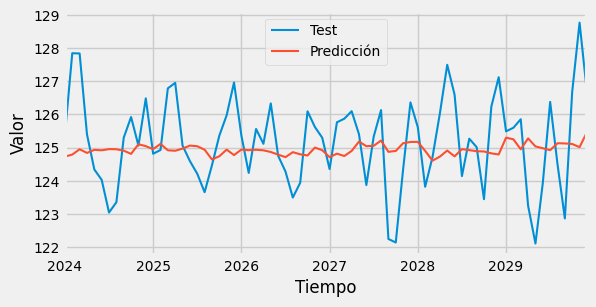

1.9625968124960491

In [250]:
backtesting_rnn_2(df26,df26_train,df26_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.7210 - val_loss: 0.0787
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1156 - val_loss: 0.0719
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0210 - val_loss: 0.0650
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0090 - val_loss: 0.0670
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - val_loss: 0.0626
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - val_loss: 0.0644
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.4859e-04 - val_loss: 0.0632
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0451e-04 - val_loss: 0.0641
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.7073e-04 - val_loss: 0.0635
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5095e-04 - val_loss: 0.0633
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0740e-04 - val_loss: 0.0638
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0214e-04 - val_loss: 0.0636
Epoch 5/8
9

  0%|          | 0/8 [00:00<?, ?it/s]

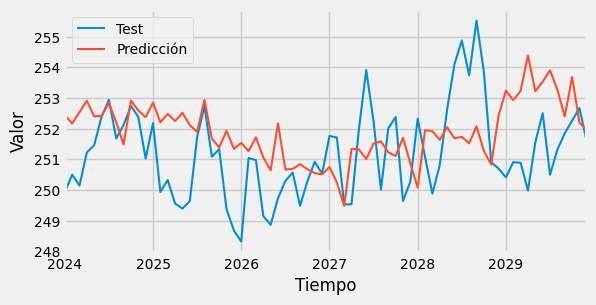

3.2146820840789108

In [251]:
backtesting_rnn_2(df27,df27_train,df27_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.8128 - val_loss: 0.1138
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1519 - val_loss: 0.0901
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0334 - val_loss: 0.0712
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0139 - val_loss: 0.0606
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0075 - val_loss: 0.0737
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0032 - val_loss: 0.0625
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0022 - val_loss: 0.0632
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012 - val_loss: 0.0665
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 8.9952e-04 - val_loss: 0.0636
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 0.0652
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010 - val_loss: 0.0640
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010 - val_loss: 0.0643
Epoch 5/8
9/9 ━━━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

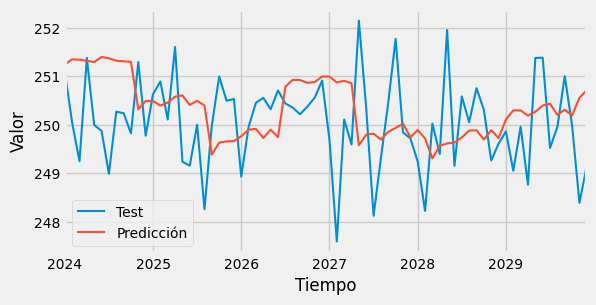

1.297730767193017

In [252]:
backtesting_rnn_2(df28,df28_train,df28_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.2907 - val_loss: 0.1369
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1185 - val_loss: 0.0587
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0546 - val_loss: 0.0377
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0421 - val_loss: 0.0364
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0405 - val_loss: 0.0340
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0386 - val_loss: 0.0332
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0377 - val_loss: 0.0330
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0367 - val_loss: 0.0329
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0363 - val_loss: 0.0328
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0367 - val_loss: 0.0324
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0363 - val_loss: 0.0325
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0371 - val_loss: 0.0323
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0

  0%|          | 0/8 [00:00<?, ?it/s]

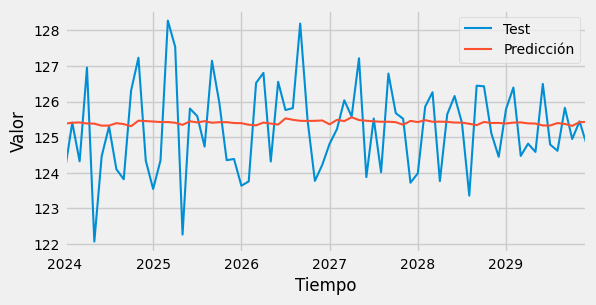

1.610522745736961

In [253]:
backtesting_rnn_2(df29,df29_train,df29_test,[columna],10,20,8,30,144)

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.6509 - val_loss: 0.1649
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2401 - val_loss: 0.1617
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0702 - val_loss: 0.1340
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0122 - val_loss: 0.0950
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0117 - val_loss: 0.1126
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0077 - val_loss: 0.1176
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - val_loss: 0.1016
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0050 - val_loss: 0.1055
Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0033 - val_loss: 0.1020
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0025 - val_loss: 0.1030
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - val_loss: 0.1061
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - val_loss: 0.1000
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━

  0%|          | 0/8 [00:00<?, ?it/s]

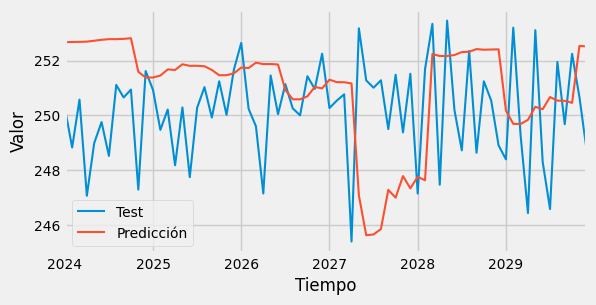

8.137751723104271

In [254]:
backtesting_rnn_2(df30,df30_train,df30_test,[columna],10,20,8,30,144)